In [2]:
%%time
dataset_name = "W19_comb"
df_list = [ "BES_Panel" ]

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}

if "id" in BES_Panel.columns:
    BES_Panel = BES_Panel.set_index("id").sort_index()

(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')



Toggle code

var_type (7911, 14)
Wall time: 23.7 s


In [3]:
BES_reduced_with_na = pd.read_pickle("E:\\BES_analysis_data"+os.sep+"BES_reduced_with_na.zip",compression='zip')

In [4]:
BES_reduced_with_na["profile_turnout_2017_Yes"]

id
1         <NA>
2         True
3         True
4         <NA>
5         <NA>
         ...  
98447    False
98448    False
98449     True
98450    False
98451     <NA>
Name: profile_turnout_2017_Yes, Length: 97158, dtype: boolean

In [12]:
search(BES_Panel,"p_turnout")

p_turnout_2015        84247
p_turnout_2017        70392
p_turnout_2019        32141
p_turnout_2010        77082
p_turnout_2005        74019
p_turnout_scot_ref    10976
dtype: int64

In [13]:
BES_Panel["p_turnout_2017"]

id
1               NaN
2             Voted
3             Voted
4               NaN
5               NaN
            ...    
98447           DNV
98448           DNV
98449         Voted
98450           DNV
98451    Don't know
Name: p_turnout_2017, Length: 97006, dtype: category
Categories (3, object): [DNV < Voted < Don't know]

In [74]:
# id_seq = pd.read_stata(BES_data_folder+os.sep+dataset_name+os.sep+"BES2019_W19_Panel_v0.1.dta",
#              columns=['id'])


In [78]:
# BES_reduced_with_na.index = id_seq["id"]
# BES_reduced_with_na = BES_reduced_with_na.sort_index()

In [87]:
# BES_reduced_with_na.to_pickle("E:\\BES_analysis_data"+os.sep+"BES_reduced_with_na.zip",compression='zip')

In [ ]:
# id_seq.to_pickle("E:\\BES_analysis_data"+os.sep+"idseq.zip",compression='zip')

In [69]:
# search(BES_reduced_with_na,"profile_turnout")

profile_turnout_2017_Yes    69817
profile_turnout_2015_Yes    76659
dtype: int64

In [6]:
BES_Panel = pd.read_pickle("..\\BES_analysis_data\\"+"W19_comb"+os.sep+"BES_Panelv02",compression='zip')
BES_Panel = BES_Panel.set_index("id")
BES_Panel = BES_Panel.sort_index()

In [7]:
BES_Panel.shape

(97006, 8079)

In [8]:
BES_reduced_with_na = BES_reduced_with_na.loc[BES_Panel.index].sort_index()

In [9]:
BES_reduced_with_na.shape

(97006, 11963)

In [14]:
#### xgboost
import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [15]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    

import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves, mask)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values, train.columns)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#     return BES_Panel["generalElectionVoteW19"].notnull()
    return 1



def create_train(drop_other_waves,mask):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list][mask].astype('float32')


def create_target(target_var):
    
    return df[target_var].astype('float32')

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.03,
 n_estimators= 600,
 max_depth=6,
 min_child_weight=8,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)

# wave_pair = ["W8","W9"]
def add_pairs(wave_pair):
    pair1_cols = [x for x in search(df,wave_pair[0]).index if x.replace(wave_pair[0],wave_pair[1]) in df.columns]
    pair2_cols = [x.replace(wave_pair[0],wave_pair[1]) for x in pair1_cols]

    prefix = "D"+"_".join([x.replace("W","") for x in wave_pair])
    delta_df = pd.DataFrame(df[pair2_cols].values - df[pair1_cols].values,
                            columns = [prefix+x.replace(wave_pair[0],"") for x in pair1_cols])
    if pair1_cols!=[]:
        biggest_dtype = df[pair1_cols].dtypes.value_counts().index[-1].name
        biggest_dtype = "Int64" # nino_df screws this up by introducing floats!
        delta_df = delta_df.astype(biggest_dtype).astype('float32')
        df[delta_df.columns] = delta_df
    
def shap_array(shap_values, train_columns, threshold = .1, min_features = 50):

    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    return pd.Series(global_shap_vals[inds][::-1],index = train_columns[inds][::-1])    

def hash_df(sourcedf,destinationdf,*column):
    columnName = ''
    destinationdf['hash_'+columnName.join(column)] = pd.DataFrame(sourcedf[list(column)].values.sum(axis=1))[0].str.encode('utf-8').apply(lambda x: (hashlib.sha512(x).hexdigest().upper()))
# hash_df(df,df,'ID','Salt')

def drop_duplicate_columns(df):
    return df.loc[:,~df.columns.duplicated()]

In [46]:
BES_media_dummies = pd.read_csv("C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_data\\W19_comb_strings\\BES_media_vars_dummied.csv")
BES_media_dummies = BES_media_dummies.set_index("id")

count=1
for med_col in BES_media_dummies.columns:
#     print(count)
    count=count+1
    BES_media_dummies.loc[BES_Panel[ "_".join(med_col.split("_")[:-1]) ].isnull(),med_col] = np.nan

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [64]:
BES_media_dummies.astype('float32').to_pickle(BES_data_folder+"\\W19_comb_strings\\BES_media_vars_dummied_with_nulls.zip",compression='zip')
#

In [63]:
BES_data_folder

'../BES_analysis_data/'

In [47]:
BES_media_dummies.isnull().sum()

p_paper_readW1_The Express                                    66623
p_paper_readW1_The Daily Mail / The Scottish Daily Mail       66623
p_paper_readW1_The Mirror / Daily Record                      66623
p_paper_readW1_The Daily Star / The Daily Star of Scotland    66623
p_paper_readW1_The Sun                                        66623
                                                              ...  
euSources_3W8_Yes                                             63504
euSources_4W8_No                                              63504
euSources_4W8_Yes                                             63504
euSources_5W8_No                                              63504
euSources_5W8_Yes                                             63504
Length: 675, dtype: int64

In [48]:
BES_strings=pd.read_pickle('../BES_analysis_data/W19_comb_strings\\BES2019_W19Strings_v0.3.zip', compression='zip')

In [49]:
tvradiopaperinternet_dummied = pd.read_csv("C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_data\\W19_comb_strings\\tvradiopaperinternet_dummied.csv")
tvradiopaperinternet_dummied = tvradiopaperinternet_dummied.set_index("id")

In [58]:
count=1
for med_col in tvradiopaperinternet_dummied.columns:
#     print(count)
    count=count+1
    
    mask = BES_strings[match(BES_strings,"_".join(med_col.split("_")[:-1])).index].replace("__na__",np.nan).isnull().all(axis=1)
    tvradiopaperinternet_dummied.loc[mask , med_col] = np.nan

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [59]:
tvradiopaperinternet_dummied.isnull().sum()

tv_bbc news                        69272
tv_question time                   69272
tv_newsnight                       69272
tv_news                            69272
tv_sky news                        69272
                                   ...  
internet_le monde                  76512
internet_eu referendum             76512
internet_daily post                76512
internet_electionforecast.co.uk    76512
internet_lbc                       76512
Length: 584, dtype: int64

In [70]:
tvradiopaperinternet_dummied.astype('float32').to_pickle(BES_data_folder+"\\W19_comb_strings\\tvradiopaperinternet_dummied_with_nulls.zip",compression='zip')
#

In [71]:
q1_dummied = pd.read_csv("C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_data\\W19_comb_strings\\q1_dummied.csv")
q1_dummied = q1_dummied.set_index("id")

In [72]:
count=1
for med_col in q1_dummied.columns:
#     print(count)
    count=count+1
    
    mask = BES_strings[match(BES_strings,"q1").index].replace("__na__",np.nan).isnull().all(axis=1)
    q1_dummied.loc[mask , med_col] = np.nan

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


In [73]:
q1_dummied.isnull().sum()

q1_regional news and weather                                       76966
q1_bbc news                                                        76966
q1_breakfast                                                       76966
q1_bbc news at ten                                                 76966
q1_bbc news at six                                                 76966
                                                                   ...  
q1_party election broadcast on behalf of plaid cymru               76966
q1_party election broadcast on behalf of the labour party          76966
q1_your questions answered                                         76966
q1_party election broadcast on behalf of the liberal democrats     76966
q1_party election broadcast on behalf of the conservative party    76966
Length: 115, dtype: int64

In [74]:
q1_dummied.astype('float32').to_pickle(BES_data_folder+"\\W19_comb_strings\\q1_dummied_with_nulls.zip",compression='zip')

In [18]:
treatment_dict = {}

[11:49:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.86639
Will train until validation_0-rmse hasn't improved in 60.0 rounds.
[1]	validation_0-rmse:3.80083
[2]	validation_0-rmse:3.73777
[3]	validation_0-rmse:3.67696
[4]	validation_0-rmse:3.61838
[5]	validation_0-rmse:3.56225
[6]	validation_0-rmse:3.50884
[7]	validation_0-rmse:3.45978
[8]	validation_0-rmse:3.41129
[9]	validation_0-rmse:3.36508
[10]	validation_0-rmse:3.32187
[11]	validation_0-rmse:3.279
[12]	validation_0-rmse:3.23935
[13]	validation_0-rmse:3.20133
[14]	validation_0-rmse:3.16407
[15]	validation_0-rmse:3.12882
[16]	validation_0-rmse:3.0952
[17]	validation_0-rmse:3.06392
[18]	validation_0-rmse:3.03359
[19]	validation_0-rmse:3.00519
[20]	validation_0-rmse:2.97736
[21]	validation_0-rmse:2.95104
[22]	validation_0-rmse:2.92621
[23]	validation_0-rmse:2.9023
[24]	validation_0-rmse:2.87898
[25]	validation_0-rmse:2.85745
[26]	validation_0-rmse:2.

[255]	validation_0-rmse:2.40914
[256]	validation_0-rmse:2.40926
[257]	validation_0-rmse:2.40922
[258]	validation_0-rmse:2.40922
[259]	validation_0-rmse:2.40906
[260]	validation_0-rmse:2.40909
[261]	validation_0-rmse:2.40905
[262]	validation_0-rmse:2.40905
[263]	validation_0-rmse:2.40923
[264]	validation_0-rmse:2.40923
[265]	validation_0-rmse:2.4092
[266]	validation_0-rmse:2.40918
[267]	validation_0-rmse:2.40899
[268]	validation_0-rmse:2.40916
[269]	validation_0-rmse:2.40896
[270]	validation_0-rmse:2.40867
[271]	validation_0-rmse:2.40849
[272]	validation_0-rmse:2.40859
[273]	validation_0-rmse:2.40851
[274]	validation_0-rmse:2.4085
[275]	validation_0-rmse:2.40844
[276]	validation_0-rmse:2.4083
[277]	validation_0-rmse:2.40829
[278]	validation_0-rmse:2.40832
[279]	validation_0-rmse:2.40826
[280]	validation_0-rmse:2.40831
[281]	validation_0-rmse:2.40835
[282]	validation_0-rmse:2.40832
[283]	validation_0-rmse:2.40813
[284]	validation_0-rmse:2.4081
[285]	validation_0-rmse:2.40795
[286]	valida

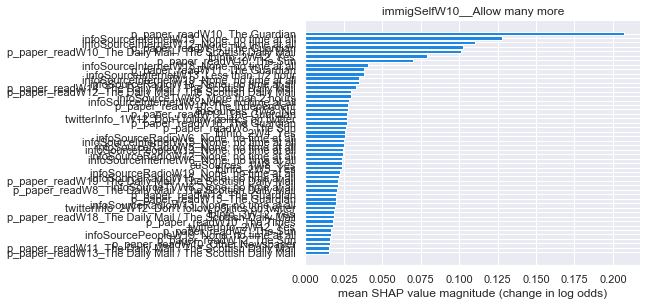

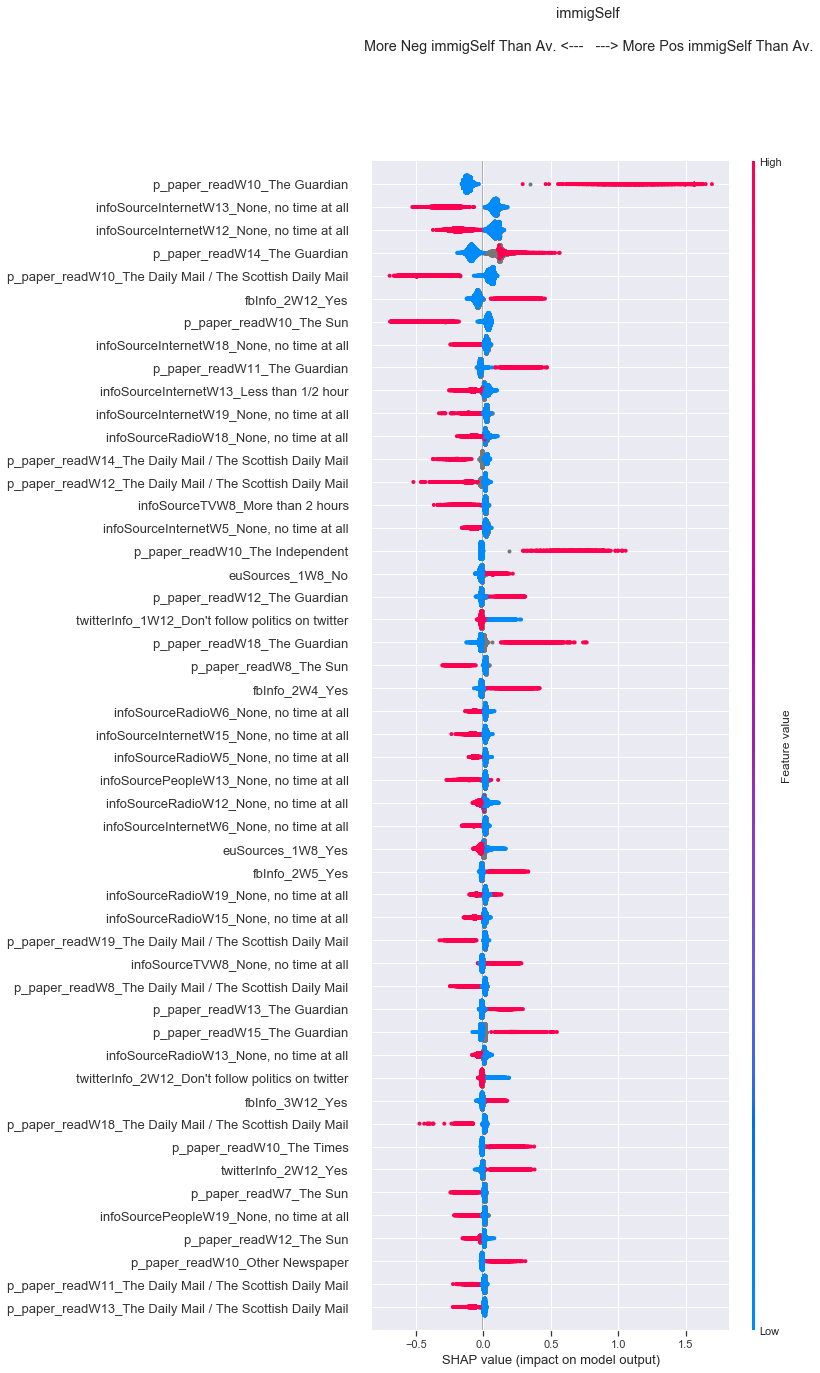

Wall time: 10min 15s


In [19]:
%%time
## target = D7_8immigEcon
# wno1 = "8"
wno2 = "10"

base = "immigSelf"

# Treatment = "D"+wno1+"_"+wno2+base+"_with_demog_variables"
Treatment = "W10"+base+"_with_media_dummies"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
df = BES_media_dummies
# var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

# mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "immigSelf"

var_list = [var2]
var_stub_list = [var_stub]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
# df[var_stub] = (BES_reduced_with_na[var2]) -\
#                       (BES_reduced_with_na[var1])[mask]  
df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)


[15:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.87236
Will train until validation_0-rmse hasn't improved in 13.600000000000001 rounds.
[1]	validation_0-rmse:3.81374
[2]	validation_0-rmse:3.75642
[3]	validation_0-rmse:3.70232
[4]	validation_0-rmse:3.64959
[5]	validation_0-rmse:3.59894
[6]	validation_0-rmse:3.55032
[7]	validation_0-rmse:3.50546
[8]	validation_0-rmse:3.46184
[9]	validation_0-rmse:3.42055
[10]	validation_0-rmse:3.38131
[11]	validation_0-rmse:3.34276
[12]	validation_0-rmse:3.30699
[13]	validation_0-rmse:3.27268
[14]	validation_0-rmse:3.23979
[15]	validation_0-rmse:3.20887
[16]	validation_0-rmse:3.17928
[17]	validation_0-rmse:3.15054
[18]	validation_0-rmse:3.12333
[19]	validation_0-rmse:3.09783
[20]	validation_0-rmse:3.07389
[21]	validation_0-rmse:3.05086
[22]	validation_0-rmse:3.02991
[23]	validation_0-rmse:3.00866
[24]	validation_0-rmse:2.98901
[25]	validation_0-rmse:2.97029
[26]	va

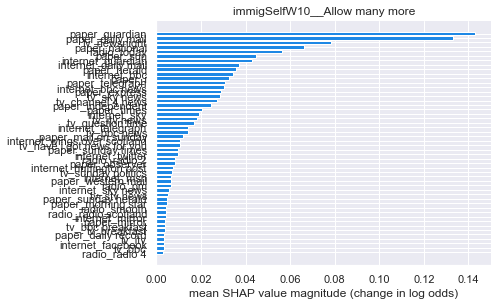

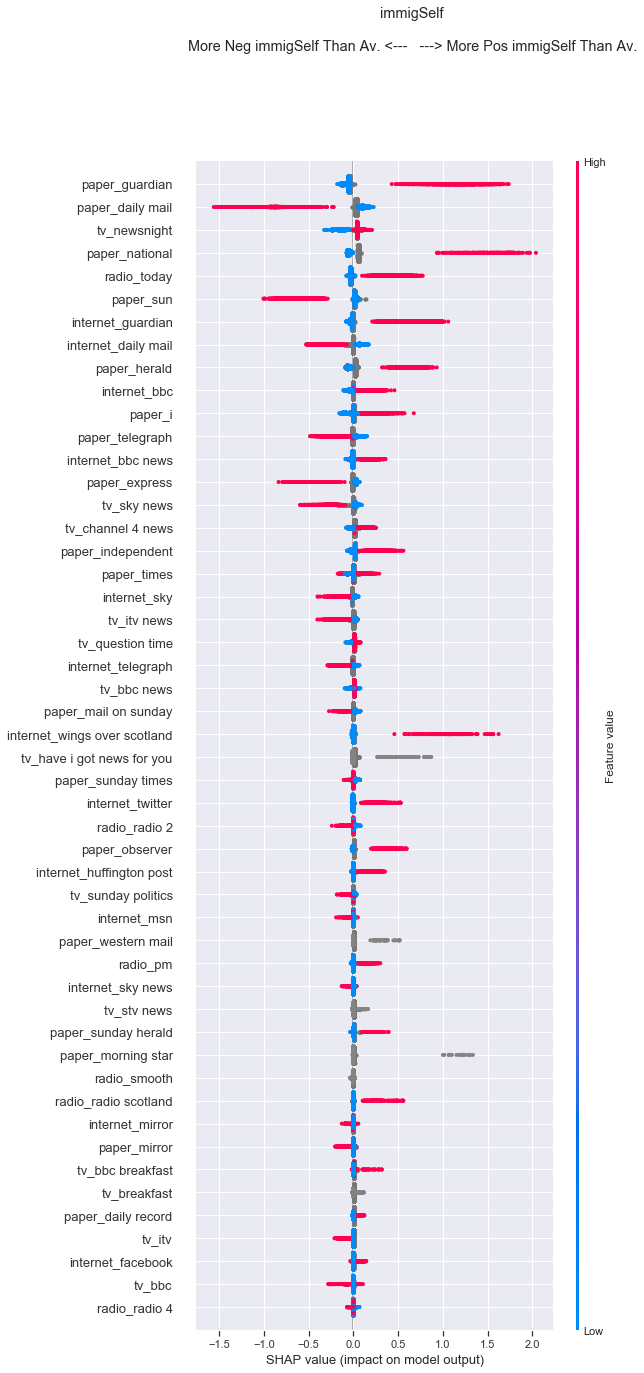

Wall time: 3min 1s


In [75]:
%%time
## target = D7_8immigEcon
# wno1 = "8"
wno2 = "10"

base = "immigSelf"


Treatment = "W10"+base+"_with_tvradiopaperinternet_dummied"

df = tvradiopaperinternet_dummied.copy()
# var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

# mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "immigSelf"

var_list = [var2]
var_stub_list = [var_stub]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
# df[var_stub] = (BES_reduced_with_na[var2]) -\
#                       (BES_reduced_with_na[var1])[mask]  
df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)


[15:46:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.25896
Will train until validation_0-rmse hasn't improved in 13.5 rounds.
[1]	validation_0-rmse:4.18624
[2]	validation_0-rmse:4.11606
[3]	validation_0-rmse:4.04927
[4]	validation_0-rmse:3.98532
[5]	validation_0-rmse:3.9241
[6]	validation_0-rmse:3.86568
[7]	validation_0-rmse:3.81018
[8]	validation_0-rmse:3.75691
[9]	validation_0-rmse:3.70584
[10]	validation_0-rmse:3.65775
[11]	validation_0-rmse:3.61117
[12]	validation_0-rmse:3.56718
[13]	validation_0-rmse:3.52493
[14]	validation_0-rmse:3.48459
[15]	validation_0-rmse:3.44633
[16]	validation_0-rmse:3.4103
[17]	validation_0-rmse:3.37638
[18]	validation_0-rmse:3.34331
[19]	validation_0-rmse:3.31199
[20]	validation_0-rmse:3.28208
[21]	validation_0-rmse:3.25406
[22]	validation_0-rmse:3.22699
[23]	validation_0-rmse:3.20146
[24]	validation_0-rmse:3.17729
[25]	validation_0-rmse:3.15449
[26]	validation_0-rmse:

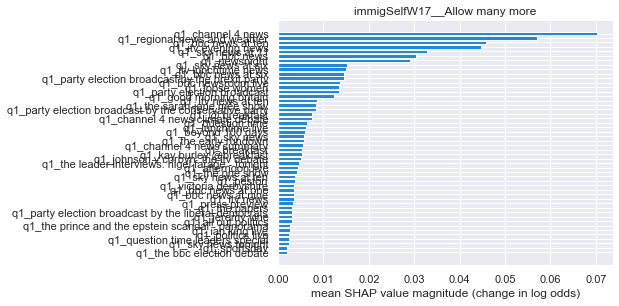

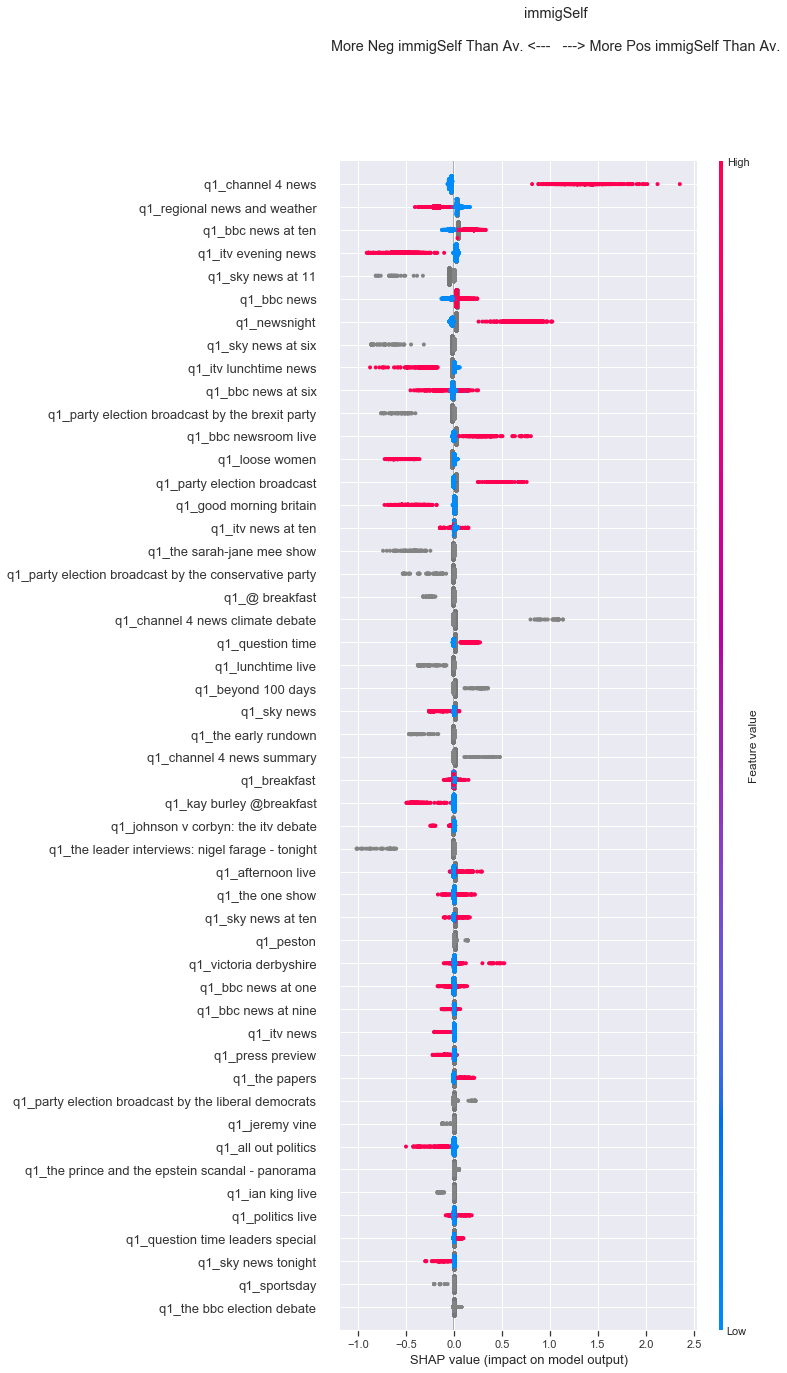

Wall time: 1min 45s


In [76]:
%%time
## target = D7_8immigEcon
# wno1 = "8"
wno2 = "17"

base = "immigSelf"


Treatment = "W"+str(wno2)+base+"_with_q1_dummied"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
df = q1_dummied
# var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

# mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "immigSelf"

var_list = [var2]
var_stub_list = [var_stub]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
# df[var_stub] = (BES_reduced_with_na[var2]) -\
#                       (BES_reduced_with_na[var1])[mask]  
df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)


In [30]:
search(BES_Panel,"immigSelf")

immigSelfW7     30895
immigSelfW8     33502
immigSelfW9     30036
immigSelfW10    30237
immigSelfW11    30956
immigSelfW12     8984
immigSelfW13     1289
immigSelfW14    31063
immigSelfW15    30842
immigSelfW16    37959
immigSelfW17    34366
dtype: int64

[12:09:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.25992
Will train until validation_0-rmse hasn't improved in 14.700000000000001 rounds.
[1]	validation_0-rmse:3.18902
[2]	validation_0-rmse:3.1205
[3]	validation_0-rmse:3.0545
[4]	validation_0-rmse:2.99115
[5]	validation_0-rmse:2.93018
[6]	validation_0-rmse:2.87179
[7]	validation_0-rmse:2.81581
[8]	validation_0-rmse:2.76209
[9]	validation_0-rmse:2.71056
[10]	validation_0-rmse:2.6609
[11]	validation_0-rmse:2.61336
[12]	validation_0-rmse:2.56748
[13]	validation_0-rmse:2.52356
[14]	validation_0-rmse:2.48133
[15]	validation_0-rmse:2.44146
[16]	validation_0-rmse:2.40322
[17]	validation_0-rmse:2.36661
[18]	validation_0-rmse:2.33133
[19]	validation_0-rmse:2.29748
[20]	validation_0-rmse:2.26488
[21]	validation_0-rmse:2.23403
[22]	validation_0-rmse:2.20482
[23]	validation_0-rmse:2.17678
[24]	validation_0-rmse:2.14993
[25]	validation_0-rmse:2.12419
[26]	valid

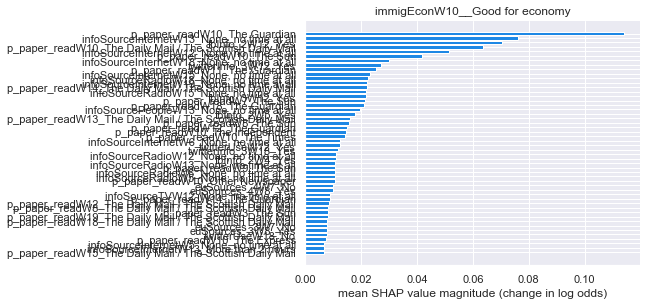

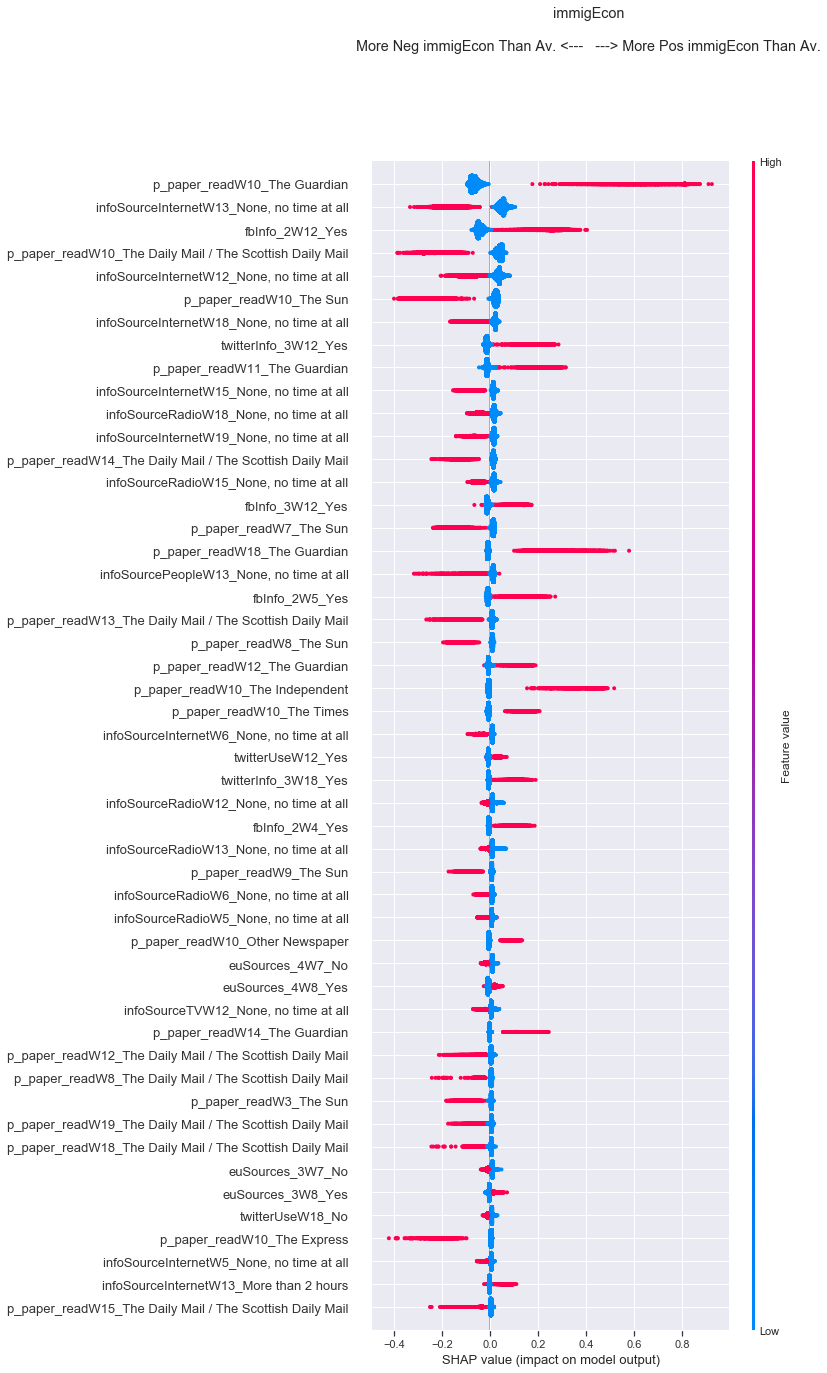

Wall time: 5min 11s


In [22]:
%%time
## target = D7_8immigEcon
# wno1 = "8"
wno2 = "10"

base = "immigEcon"

# Treatment = "D"+wno1+"_"+wno2+base+"_with_demog_variables"
Treatment = "W10"+base+"_with_media_dummies"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
# BES_media_dummies = pd.read_csv("C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_data\\W19_comb_strings\\BES_media_vars_dummied.csv")
# BES_media_dummies = BES_media_dummies.set_index("id")
df = BES_media_dummies.copy()
# var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

# mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = base

var_list = [var2]
var_stub_list = [var_stub]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
# df[var_stub] = (BES_reduced_with_na[var2]) -\
#                       (BES_reduced_with_na[var1])[mask]  
df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)


[12:14:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.2637
Will train until validation_0-rmse hasn't improved in 14.600000000000001 rounds.
[1]	validation_0-rmse:3.19672
[2]	validation_0-rmse:3.13209
[3]	validation_0-rmse:3.06977
[4]	validation_0-rmse:3.01028
[5]	validation_0-rmse:2.95321
[6]	validation_0-rmse:2.89844
[7]	validation_0-rmse:2.84612
[8]	validation_0-rmse:2.79583
[9]	validation_0-rmse:2.74803
[10]	validation_0-rmse:2.70192
[11]	validation_0-rmse:2.65766
[12]	validation_0-rmse:2.61571
[13]	validation_0-rmse:2.57531
[14]	validation_0-rmse:2.53676
[15]	validation_0-rmse:2.50001
[16]	validation_0-rmse:2.46495
[17]	validation_0-rmse:2.4317
[18]	validation_0-rmse:2.39952
[19]	validation_0-rmse:2.36881
[20]	validation_0-rmse:2.33956
[21]	validation_0-rmse:2.31166
[22]	validation_0-rmse:2.28546
[23]	validation_0-rmse:2.2604
[24]	validation_0-rmse:2.23629
[25]	validation_0-rmse:2.21349
[26]	valid

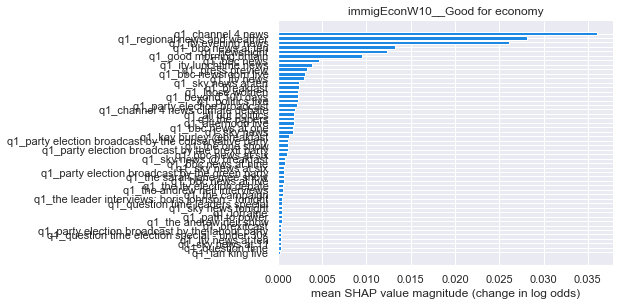

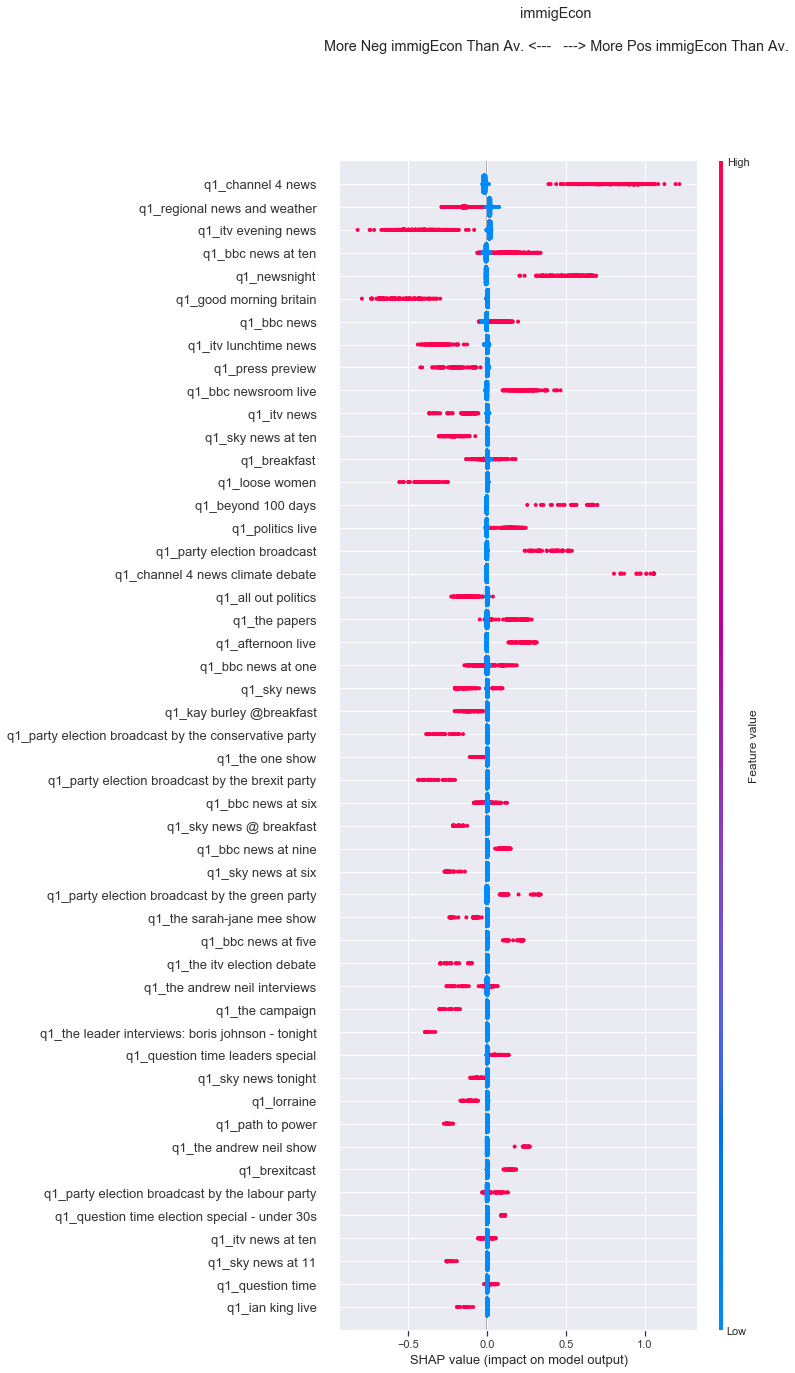

Wall time: 2min 2s


In [23]:
%%time
## target = D7_8immigEcon
# wno1 = "8"
wno2 = "10"

base = "immigEcon"

# Treatment = "D"+wno1+"_"+wno2+base+"_with_demog_variables"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
q1_dummied = pd.read_csv("C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_data\\W19_comb_strings\\q1_dummied.csv")
q1_dummied = q1_dummied.set_index("id")
Treatment = "W10"+base+"_with_q1_dummied"

df = q1_dummied
# var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

# mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = base

var_list = [var2]
var_stub_list = [var_stub]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
# df[var_stub] = (BES_reduced_with_na[var2]) -\
#                       (BES_reduced_with_na[var1])[mask]  
df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)


[12:16:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.26227
Will train until validation_0-rmse hasn't improved in 14.5 rounds.
[1]	validation_0-rmse:3.1935
[2]	validation_0-rmse:3.12752
[3]	validation_0-rmse:3.0638
[4]	validation_0-rmse:3.0025
[5]	validation_0-rmse:2.9438
[6]	validation_0-rmse:2.88832
[7]	validation_0-rmse:2.83501
[8]	validation_0-rmse:2.78291
[9]	validation_0-rmse:2.73365
[10]	validation_0-rmse:2.68611
[11]	validation_0-rmse:2.64079
[12]	validation_0-rmse:2.59733
[13]	validation_0-rmse:2.55535
[14]	validation_0-rmse:2.51549
[15]	validation_0-rmse:2.47721
[16]	validation_0-rmse:2.44098
[17]	validation_0-rmse:2.40624
[18]	validation_0-rmse:2.37296
[19]	validation_0-rmse:2.34113
[20]	validation_0-rmse:2.31072
[21]	validation_0-rmse:2.2813
[22]	validation_0-rmse:2.25388
[23]	validation_0-rmse:2.22762
[24]	validation_0-rmse:2.20234
[25]	validation_0-rmse:2.17831
[26]	validation_0-rmse:2.1

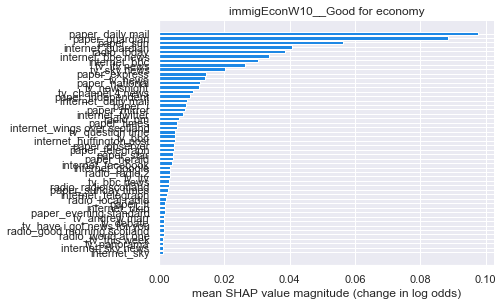

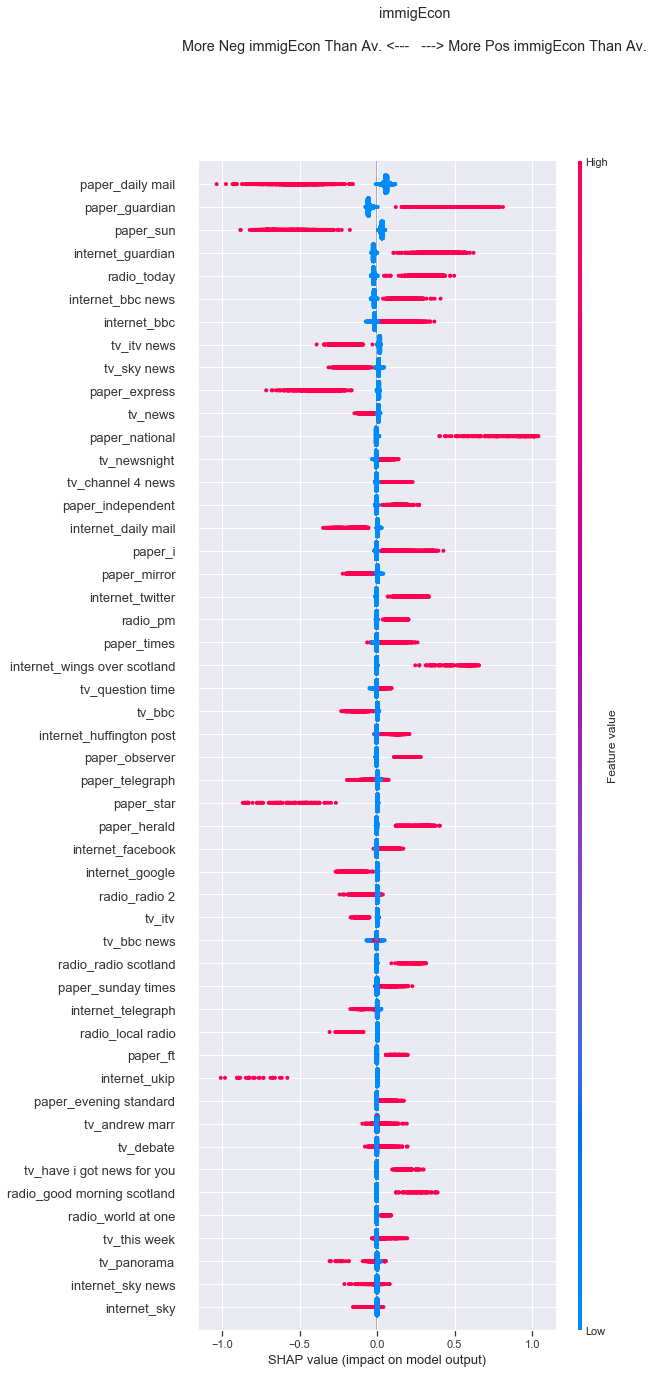

Wall time: 4min 12s


In [24]:
%%time
## target = D7_8immigEcon
# wno1 = "8"
wno2 = "10"

base = "immigEcon"

# Treatment = "D"+wno1+"_"+wno2+base+"_with_demog_variables"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
tvradiopaperinternet_dummied = pd.read_csv("C:\\Users\\Marios\\Documents\\GitHub\\BES_analysis\\BES_analysis_data\\W19_comb_strings\\tvradiopaperinternet_dummied.csv")
tvradiopaperinternet_dummied = tvradiopaperinternet_dummied.set_index("id")
Treatment = "W10"+base+"_with_tvradiopaperinternet_dummied"

df = tvradiopaperinternet_dummied
# var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

# mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = base

var_list = [var2]
var_stub_list = [var_stub]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
# df[var_stub] = (BES_reduced_with_na[var2]) -\
#                       (BES_reduced_with_na[var1])[mask]  
df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)


In [25]:
search(BES_Panel,"trust")

trustMPsW1             30566
trustYourMPW1          30566
trustMPsW2             30260
trustYourMPW2          30260
trustMPsW3             27827
trustYourMPW3          27827
trustMPsW4             31548
trustYourMPW4          31548
conGovTrustW5          30963
labGovTrustW5          30963
ldGovTrustW5           30963
snpGovTrustW5           5551
pcGovTrustW5            2962
ukipGovTrustW5         30963
grnGovTrustW5          30963
trustMPsW6             30257
trustMPsW7             30895
genTrustW7              7829
trustMPsW8              4024
trustMPsW9             30036
trustMPsW10            30237
trustMPsW12             8515
trustMPsW15             7688
genTrustW15            30842
trustMPsW16             9539
trustYourMPW16          9539
trustMPsW17            34366
trustYourMPW17          8663
trustParliamentW17     34366
trustCourtsW17         34366
genTrustW17            34366
trustMPsW18            37825
trustMPsW19            32177
genTrustW19             8105
trustWestminst

In [26]:
BES_reduced_with_na.shape

(97006, 11963)

[12:54:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.86825
Will train until validation_0-rmse hasn't improved in 13.8 rounds.
[1]	validation_0-rmse:3.80419
[2]	validation_0-rmse:3.74065
[3]	validation_0-rmse:3.67957
[4]	validation_0-rmse:3.62399
[5]	validation_0-rmse:3.56802
[6]	validation_0-rmse:3.51455
[7]	validation_0-rmse:3.46323
[8]	validation_0-rmse:3.41188
[9]	validation_0-rmse:3.36667
[10]	validation_0-rmse:3.32336
[11]	validation_0-rmse:3.28152
[12]	validation_0-rmse:3.24188
[13]	validation_0-rmse:3.20067
[14]	validation_0-rmse:3.1609
[15]	validation_0-rmse:3.12369
[16]	validation_0-rmse:3.0916
[17]	validation_0-rmse:3.05828
[18]	validation_0-rmse:3.02881
[19]	validation_0-rmse:2.99821
[20]	validation_0-rmse:2.9689
[21]	validation_0-rmse:2.94357
[22]	validation_0-rmse:2.91694
[23]	validation_0-rmse:2.89375
[24]	validation_0-rmse:2.87157
[25]	validation_0-rmse:2.84788
[26]	validation_0-rmse:2

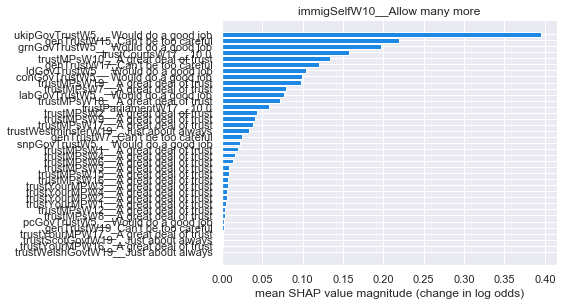

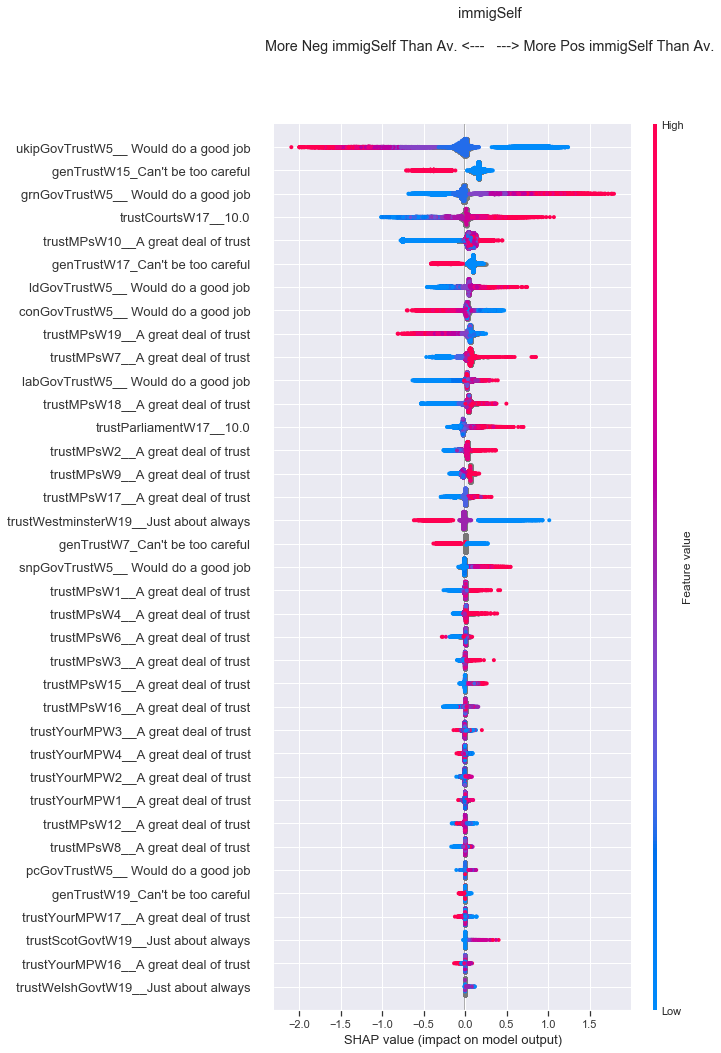

Wall time: 2min 29s


In [41]:
%%time
## target = D7_8immigEcon
# wno1 = "8"
wno2 = "10"

base = "immigSelf"

# Treatment = "D"+wno1+"_"+wno2+base+"_with_demog_variables"
Treatment = "W10"+base+"_with_trust_variables"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
df = BES_reduced_with_na[search(BES_reduced_with_na,"trust").index].astype('float32').copy()
# var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

# mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "immigSelf"

var_list = [var2]
var_stub_list = [var_stub]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
# df[var_stub] = (BES_reduced_with_na[var2]) -\
#                       (BES_reduced_with_na[var1])[mask]  
df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(df.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = min(50,df.shape[1]-1))


In [43]:
match(BES_reduced_with_na,"trust[^WS]")

trustMPsW1__A great deal of trust        29864
trustYourMPW1__A great deal of trust     27494
trustMPsW2__A great deal of trust        29532
trustYourMPW2__A great deal of trust     27466
trustMPsW3__A great deal of trust        27071
trustYourMPW3__A great deal of trust     25083
trustMPsW4__A great deal of trust        30737
trustYourMPW4__A great deal of trust     28352
trustMPsW6__A great deal of trust        29666
trustMPsW7__A great deal of trust        30175
trustMPsW8__A great deal of trust         3948
trustMPsW9__A great deal of trust        29286
trustMPsW10__A great deal of trust       29289
trustMPsW12__A great deal of trust        8243
trustMPsW15__A great deal of trust        7465
trustMPsW16__A great deal of trust        8930
trustYourMPW16__A great deal of trust     7977
trustMPsW17__A great deal of trust       33158
trustYourMPW17__A great deal of trust     7652
trustParliamentW17__10.0                 33018
trustCourtsW17__10.0                     32586
trustMPsW18__

[13:06:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.87209
Will train until validation_0-rmse hasn't improved in 13.700000000000001 rounds.
[1]	validation_0-rmse:3.81247
[2]	validation_0-rmse:3.75474
[3]	validation_0-rmse:3.69994
[4]	validation_0-rmse:3.64625
[5]	validation_0-rmse:3.59551
[6]	validation_0-rmse:3.54799
[7]	validation_0-rmse:3.5013
[8]	validation_0-rmse:3.45761
[9]	validation_0-rmse:3.41651
[10]	validation_0-rmse:3.37757
[11]	validation_0-rmse:3.33889
[12]	validation_0-rmse:3.30268
[13]	validation_0-rmse:3.2673
[14]	validation_0-rmse:3.23481
[15]	validation_0-rmse:3.20336
[16]	validation_0-rmse:3.17423
[17]	validation_0-rmse:3.14592
[18]	validation_0-rmse:3.11846
[19]	validation_0-rmse:3.09226
[20]	validation_0-rmse:3.06772
[21]	validation_0-rmse:3.04492
[22]	validation_0-rmse:3.02246
[23]	validation_0-rmse:3.00097
[24]	validation_0-rmse:2.98159
[25]	validation_0-rmse:2.96314
[26]	vali

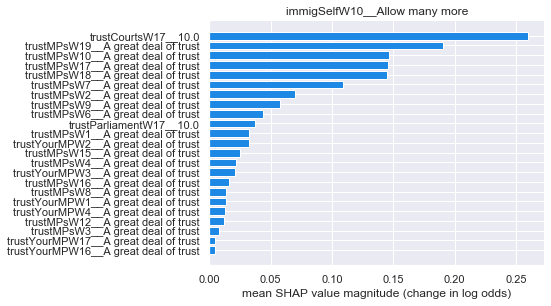

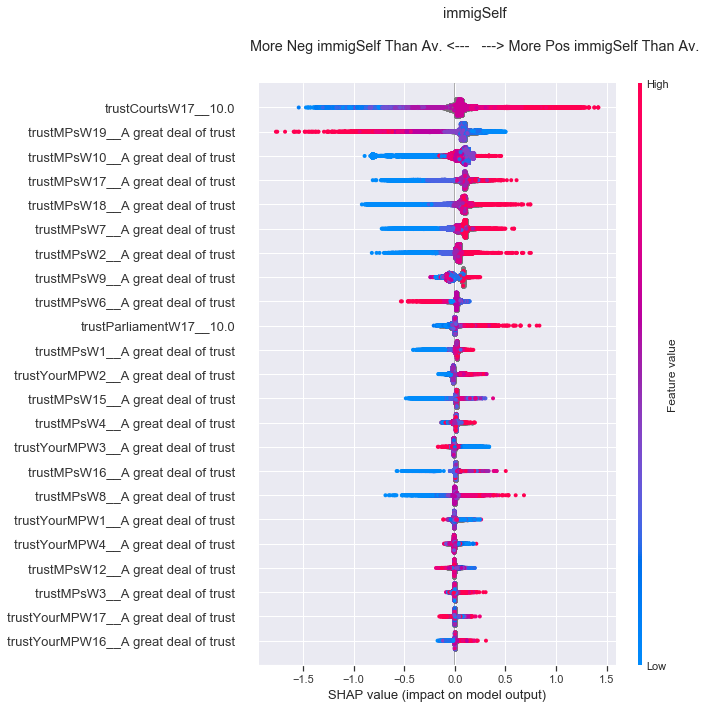

Wall time: 2min 14s


In [44]:
%%time
## target = D7_8immigEcon
# wno1 = "8"
wno2 = "10"

base = "immigSelf"

# Treatment = "D"+wno1+"_"+wno2+base+"_with_demog_variables"
Treatment = "W10"+base+"_with_trust_variables_narrow"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
df = BES_reduced_with_na[match(BES_reduced_with_na,"trust[^WS]").index].astype('float32').copy()
# var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

# mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "immigSelf"

var_list = [var2]
var_stub_list = [var_stub]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
# df[var_stub] = (BES_reduced_with_na[var2]) -\
#                       (BES_reduced_with_na[var1])[mask]  
df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(df.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = min(50,df.shape[1]-1))


In [ ]:
# deltas

[01:27:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.89685
Will train until validation_0-rmse hasn't improved in 13.4 rounds.
[1]	validation_0-rmse:1.89476
[2]	validation_0-rmse:1.89268
[3]	validation_0-rmse:1.8909
[4]	validation_0-rmse:1.889
[5]	validation_0-rmse:1.88737
[6]	validation_0-rmse:1.88593
[7]	validation_0-rmse:1.88466
[8]	validation_0-rmse:1.88343
[9]	validation_0-rmse:1.8822
[10]	validation_0-rmse:1.88086
[11]	validation_0-rmse:1.8798
[12]	validation_0-rmse:1.87904
[13]	validation_0-rmse:1.87807
[14]	validation_0-rmse:1.87708
[15]	validation_0-rmse:1.87633
[16]	validation_0-rmse:1.87559
[17]	validation_0-rmse:1.8746
[18]	validation_0-rmse:1.87369
[19]	validation_0-rmse:1.87287
[20]	validation_0-rmse:1.87214
[21]	validation_0-rmse:1.87152
[22]	validation_0-rmse:1.87106
[23]	validation_0-rmse:1.87053
[24]	validation_0-rmse:1.87013
[25]	validation_0-rmse:1.8698
[26]	validation_0-rmse:1.869

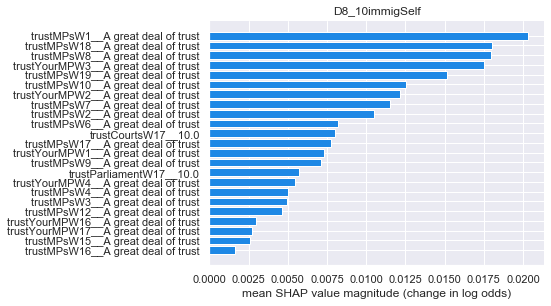

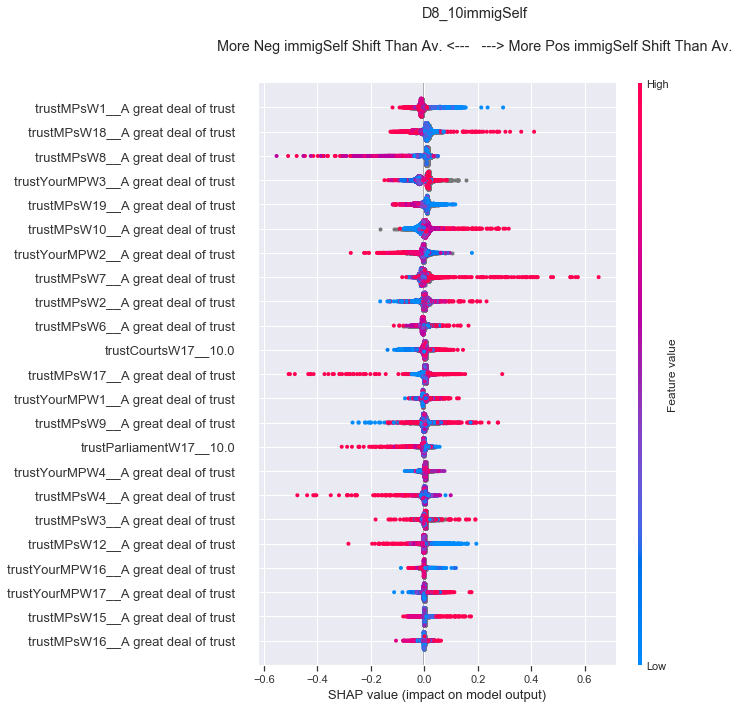

Wall time: 42.9 s


In [228]:
%%time
## target = D7_8immigEcon
wno1 = "8"
wno2 = "10"

base = "immigSelf"

Treatment = "D"+wno1+"_"+wno2+base+"_with_trust_variables_narrow"
# Treatment = "W10"+base+"_with_trust_variables_narrow"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
df = BES_reduced_with_na[match(BES_reduced_with_na,"trust[^WS]").index].astype('float32').copy()
var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
# mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "D8_10immigSelf"

var_list = [var_stub]
var_stub_list = [base]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
df[var_stub] = (BES_reduced_with_na[var2]) -\
                      (BES_reduced_with_na[var1])[mask]  
# df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(df.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Shift Than Av. <---   ---> More Pos "+base+" Shift Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = min(50,df.shape[1]-1))


[01:28:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.89662
Will train until validation_0-rmse hasn't improved in 6.2 rounds.
[1]	validation_0-rmse:1.89428
[2]	validation_0-rmse:1.89234
[3]	validation_0-rmse:1.8905
[4]	validation_0-rmse:1.88853
[5]	validation_0-rmse:1.88705
[6]	validation_0-rmse:1.88543
[7]	validation_0-rmse:1.88396
[8]	validation_0-rmse:1.88228
[9]	validation_0-rmse:1.8809
[10]	validation_0-rmse:1.87951
[11]	validation_0-rmse:1.87825
[12]	validation_0-rmse:1.87726
[13]	validation_0-rmse:1.87632
[14]	validation_0-rmse:1.87517
[15]	validation_0-rmse:1.87393
[16]	validation_0-rmse:1.87303
[17]	validation_0-rmse:1.87217
[18]	validation_0-rmse:1.87144
[19]	validation_0-rmse:1.87055
[20]	validation_0-rmse:1.86994
[21]	validation_0-rmse:1.86947
[22]	validation_0-rmse:1.86882
[23]	validation_0-rmse:1.86822
[24]	validation_0-rmse:1.86782
[25]	validation_0-rmse:1.8672
[26]	validation_0-rmse:1.

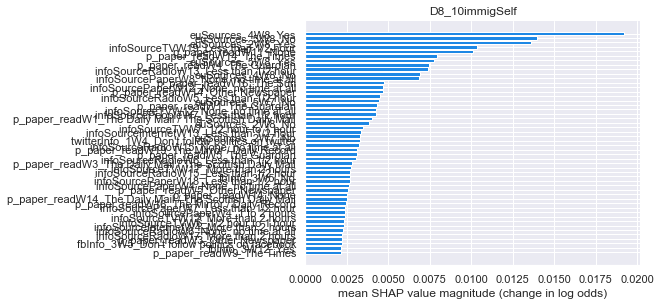

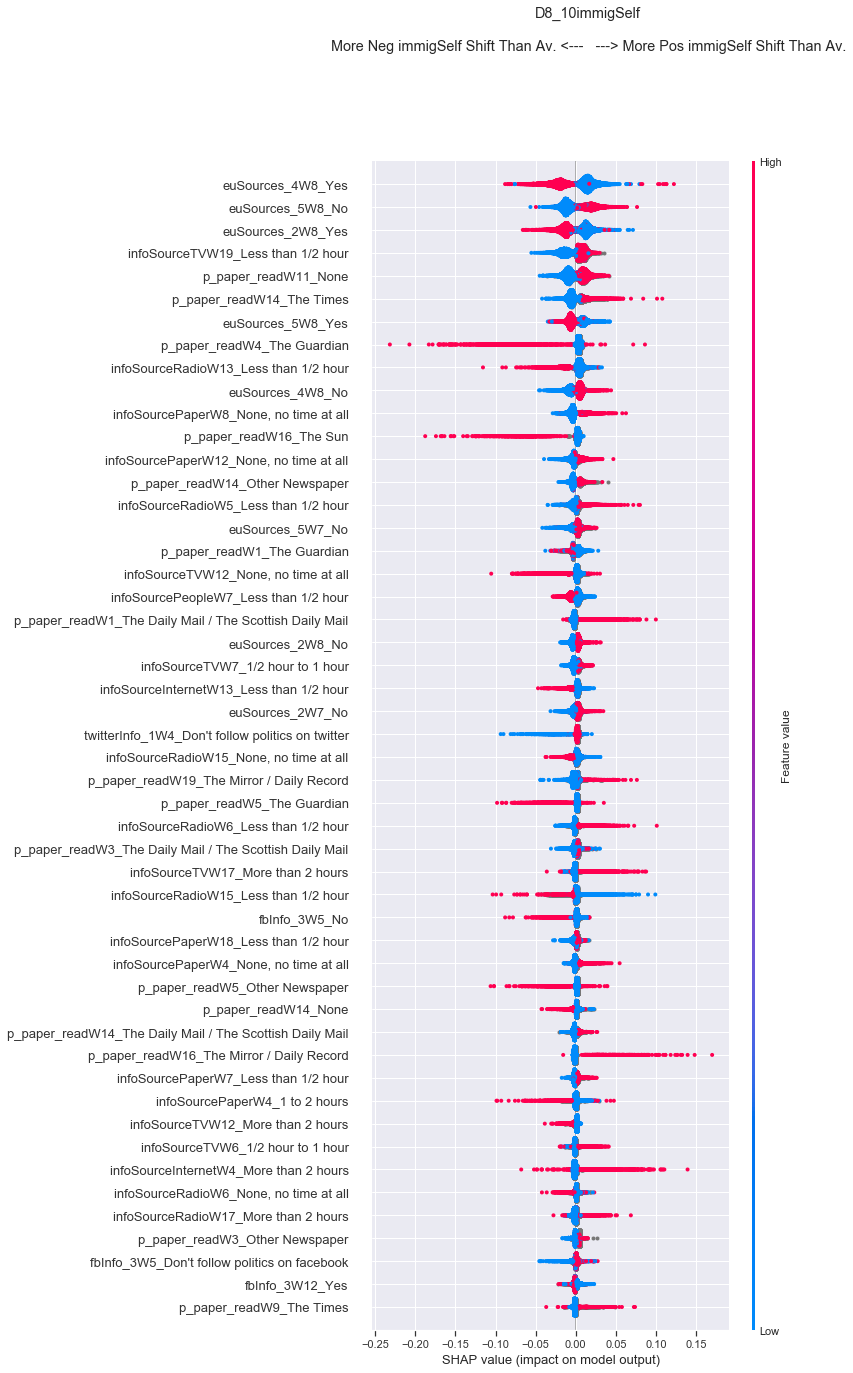

Wall time: 1min 41s


In [229]:
%%time
## target = D7_8immigEcon
wno1 = "8"
wno2 = "10"

base = "immigSelf"

Treatment = "D"+wno1+"_"+wno2+base+"_with_media_dummies"
# Treatment = "W10"+base+"_with_trust_variables_narrow"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
# df = BES_reduced_with_na[match(BES_reduced_with_na,"trust[^WS]").index].astype('float32').copy()
df = BES_media_dummies.copy()
var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
# mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "D8_10immigSelf"

var_list = [var_stub]
var_stub_list = [base]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
df[var_stub] = (BES_reduced_with_na[var2]) -\
                      (BES_reduced_with_na[var1])[mask]  
# df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(df.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Shift Than Av. <---   ---> More Pos "+base+" Shift Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = min(50,df.shape[1]-1))


[01:30:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.89666
Will train until validation_0-rmse hasn't improved in 5.800000000000001 rounds.
[1]	validation_0-rmse:1.89466
[2]	validation_0-rmse:1.89268
[3]	validation_0-rmse:1.89096
[4]	validation_0-rmse:1.88916
[5]	validation_0-rmse:1.8875
[6]	validation_0-rmse:1.88602
[7]	validation_0-rmse:1.8845
[8]	validation_0-rmse:1.88288
[9]	validation_0-rmse:1.88142
[10]	validation_0-rmse:1.88024
[11]	validation_0-rmse:1.87896
[12]	validation_0-rmse:1.87796
[13]	validation_0-rmse:1.87692
[14]	validation_0-rmse:1.87591
[15]	validation_0-rmse:1.87489
[16]	validation_0-rmse:1.87393
[17]	validation_0-rmse:1.87315
[18]	validation_0-rmse:1.87243
[19]	validation_0-rmse:1.87162
[20]	validation_0-rmse:1.87103
[21]	validation_0-rmse:1.87016
[22]	validation_0-rmse:1.86965
[23]	validation_0-rmse:1.86908
[24]	validation_0-rmse:1.8686
[25]	validation_0-rmse:1.868
[26]	validati

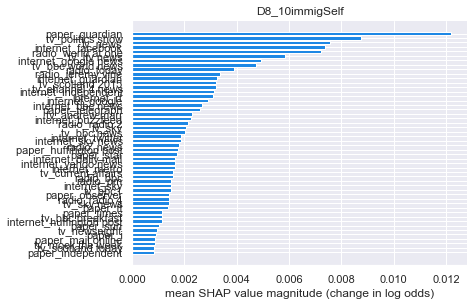

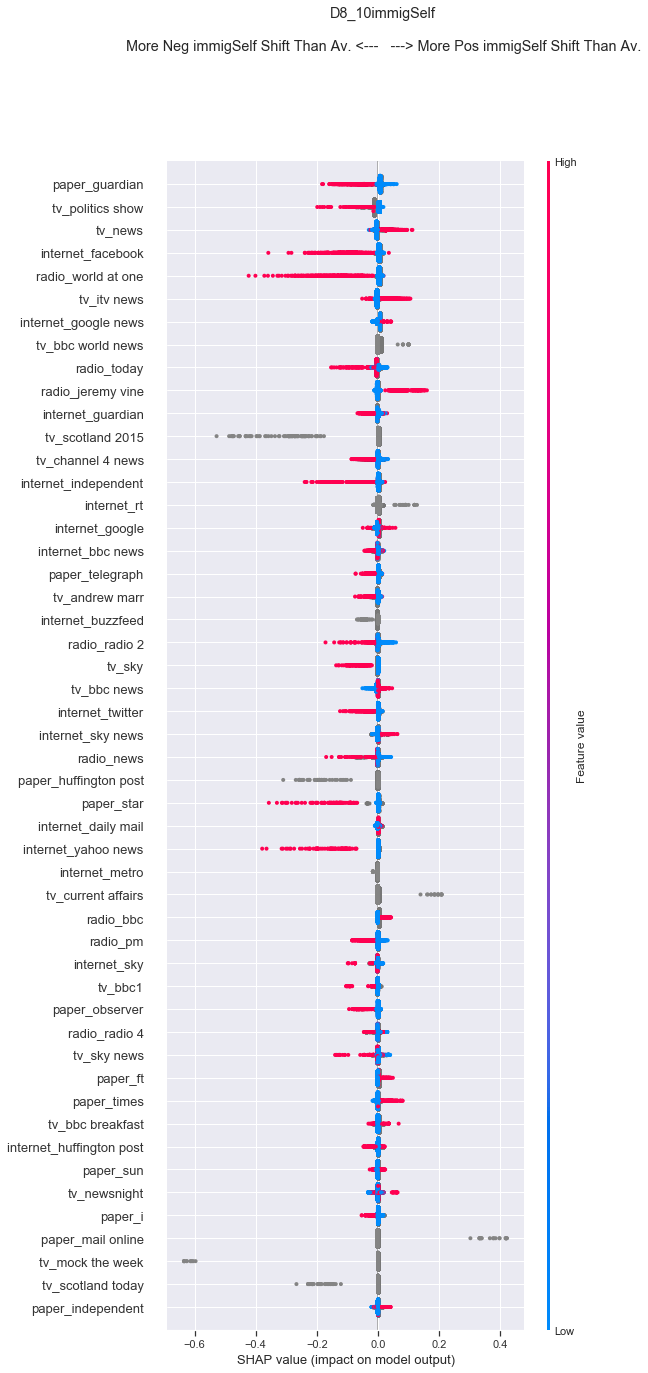

Wall time: 1min 9s


In [230]:
%%time
## target = D7_8immigEcon
wno1 = "8"
wno2 = "10"

base = "immigSelf"

Treatment = "D"+wno1+"_"+wno2+base+"_with_tvradiopaperinternet_dummied"
# Treatment = "W10"+base+"_with_trust_variables_narrow"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
# df = BES_reduced_with_na[match(BES_reduced_with_na,"trust[^WS]").index].astype('float32').copy()

# Treatment = "W10"+base+"_with_tvradiopaperinternet_dummied"

# df = tvradiopaperinternet_dummied.copy()

df = tvradiopaperinternet_dummied.copy()
var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
# mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "D8_10immigSelf"

var_list = [var_stub]
var_stub_list = [base]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
df[var_stub] = (BES_reduced_with_na[var2]) -\
                      (BES_reduced_with_na[var1])[mask]  
# df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(df.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Shift Than Av. <---   ---> More Pos "+base+" Shift Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = min(50,df.shape[1]-1))


[01:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.89677
Will train until validation_0-rmse hasn't improved in 5.7 rounds.
[1]	validation_0-rmse:1.89466
[2]	validation_0-rmse:1.89267
[3]	validation_0-rmse:1.89093
[4]	validation_0-rmse:1.88904
[5]	validation_0-rmse:1.88746
[6]	validation_0-rmse:1.88599
[7]	validation_0-rmse:1.88454
[8]	validation_0-rmse:1.88314
[9]	validation_0-rmse:1.88186
[10]	validation_0-rmse:1.88065
[11]	validation_0-rmse:1.87947
[12]	validation_0-rmse:1.87837
[13]	validation_0-rmse:1.87732
[14]	validation_0-rmse:1.87635
[15]	validation_0-rmse:1.87541
[16]	validation_0-rmse:1.87463
[17]	validation_0-rmse:1.87373
[18]	validation_0-rmse:1.873
[19]	validation_0-rmse:1.87229
[20]	validation_0-rmse:1.87172
[21]	validation_0-rmse:1.87112
[22]	validation_0-rmse:1.87062
[23]	validation_0-rmse:1.8701
[24]	validation_0-rmse:1.86964
[25]	validation_0-rmse:1.86917
[26]	validation_0-rmse:1.

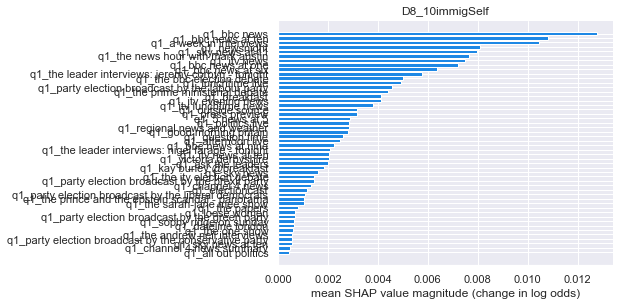

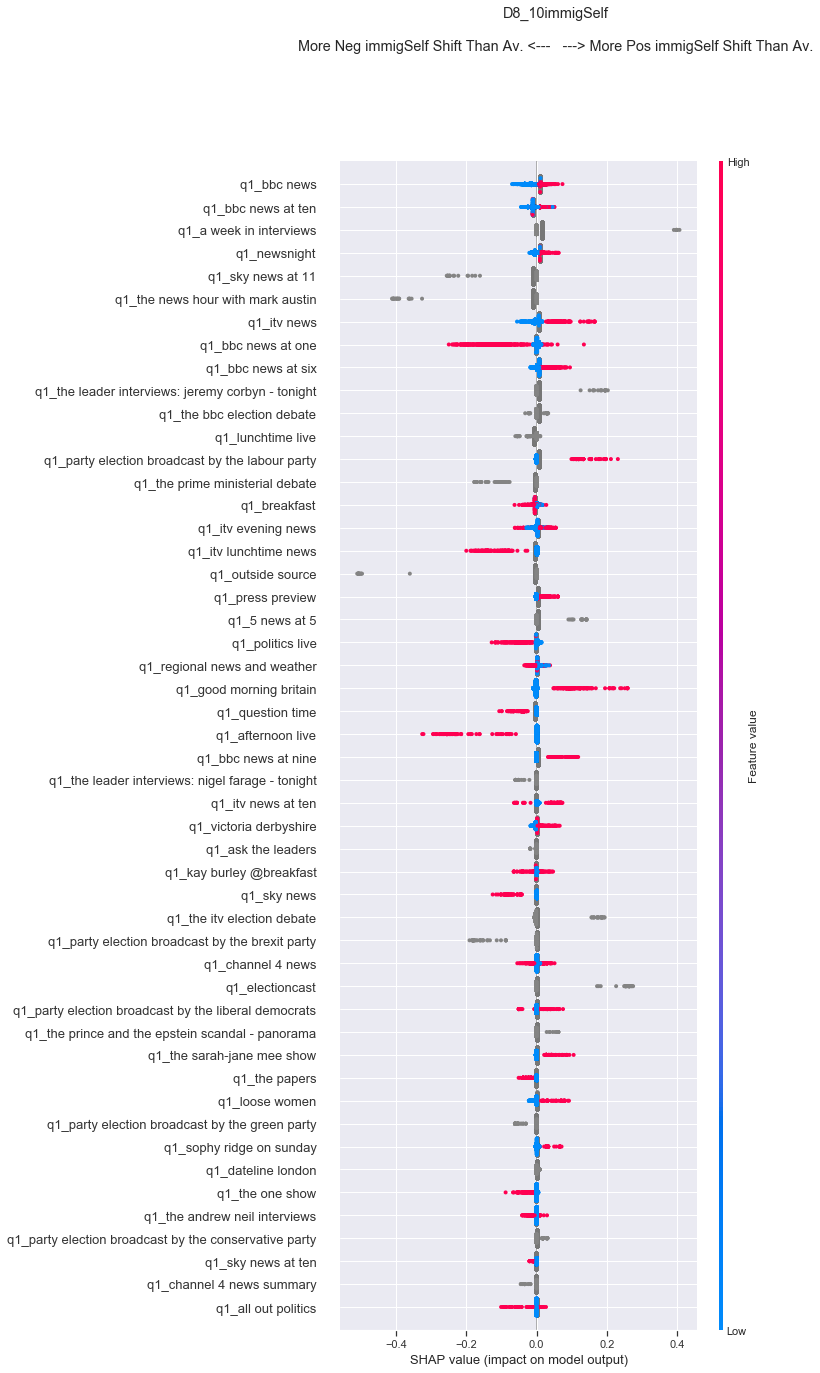

Wall time: 38.6 s


In [231]:
%%time
## target = D7_8immigEcon
wno1 = "8"
wno2 = "10"

base = "immigSelf"

Treatment = "D"+wno1+"_"+wno2+base+"_with_q1_dummied"
# Treatment = "W10"+base+"_with_trust_variables_narrow"

# wave_list = ["W"+str(x) for x in range(10,18)]

# df = BES_reduced_with_na.copy()
#[search(BES_reduced_with_na,"|".join( ["W"+wno1,"W"+wno2] ) ).index].copy()
# df = BES_reduced_with_na[match(BES_reduced_with_na,"trust[^WS]").index].astype('float32').copy()

# Treatment = "W10"+base+"_with_tvradiopaperinternet_dummied"

# df = tvradiopaperinternet_dummied.copy()

df = q1_dummied.copy()
var1 = match(BES_reduced_with_na,base+"W"+wno1).index[0]
var2 = match(BES_reduced_with_na,base+"W"+wno2).index[0]

mask = BES_reduced_with_na[var1].notnull() & BES_reduced_with_na[var2].notnull()
# mask = BES_reduced_with_na[var2].notnull()

# df = BES_reduced_with_na[ match(BES_reduced_with_na, demog_var ).index ][mask].copy()

var_stub = "D8_10immigSelf"

var_list = [var_stub]
var_stub_list = [base]

# add_pairs(["W8","W10"])

# for wno1 in range(0,len(wave_list)):
#     for wno2 in range(wno1+1,len(wave_list)):
#         print(wave_list[wno1],wave_list[wno2])
#         add_pairs([wave_list[wno1],wave_list[wno2]])
# add_pairs(["W"+wno1,"W"+wno2])
# add_pairs(["W9","W10"])
df[var_stub] = (BES_reduced_with_na[var2]) -\
                      (BES_reduced_with_na[var1])[mask]  
# df[var2] = BES_reduced_with_na[var2][mask]
# df[var_stub] = (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno2).index[0]]) -\
#                       (BES_reduced_with_na[match(BES_reduced_with_na,base+"W"+wno1).index[0]])
# df = df[df[var_stub].notnull()]

(explainer, shap_values, train_columns) = xgboost_run(subdir=Treatment,min_features = min(df.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Shift Than Av. <---   ---> More Pos "+base+" Shift Than Av.", Treatment=Treatment)
treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = min(50,df.shape[1]-1))


In [ ]:
## demographic variables

"homeOwn","secondHome","buyHomeFuture","savings","debt","studentloan",
"homeamtb","mortgagePayment","secondHomeAmtb","rentPayment","savingsAmtb","debtAmtb",
"borrowEssentials","smallEmergency","worryEconSecurity",
"riskPoverty","riskUnemployment",
"numChildren",
"forcedSubjClass","subjClass","subjClassSqueeze",
"currentUnionMember","everUnionMember",
"abroadCountry","livedAbroad","handed","languageSkills",

In [294]:
BES_reduced_with_na["goldthorpeW6W7W8W9"] = BES_Panel["ns_sec_analyticW6W7W8W9"].cat.codes.replace(-1,np.nan)

In [295]:
BES_reduced_with_na["p_disabilityW10__Yes, limited a lot"] = BES_Panel["p_disabilityW10"].cat.reorder_categories(['No', 'Yes, limited a little', 'Yes, limited a lot']).cat.codes.replace(-1,np.nan)

In [296]:
BES_reduced_with_na["p_parentW10__Yes"] = BES_Panel["p_parentW10"].cat.codes.replace(-1,np.nan)

In [298]:
# old_to_new_dict_varnames = pd.read_pickle("..\\BES_analysis_data\\"+"W19_comb"+os.sep+"old_to_new_dict_varnames.zip",compression='zip')

In [282]:
# demog_var = "travelEU|passportUK|passportOther|passportExpired|passportNever|livedAbroad|friendsEU|parentsForeign|motherCountryBorn|fatherCountryBorn"
# demog_var = "|".join([demog_var,"ukCitizenW14|euCitizenW14|commonwealthCitizenW14|otherCitizenW14"])

# demog_var = "|".join([demog_var,"gorW10|p_educationW8|p_education_ageW10|p_edlevelUniW10|anyUniW10"])
# demog_var = "|".join([demog_var,"privPrimSchlW1_W4W7W9_W12W14W15|privScndSchlW1_W4W7W9_W12W14W15|neverPrivSchlW1_W4W7W9_W12W14W15|prvSchDKW1_W4W7W9_W12W14W15"])
# demog_var = "|".join([demog_var,"p_maritalW10|gender[^R]|p_disabilityW10|p_ethnicityW10|p_religionW10|p_sexualityW10"])
# demog_var = "|".join([demog_var,"p_hh_sizeW10[^W]"])
# demog_var = "|".join([demog_var,"preschoolKidsInHouseW6_W14|preschoolKidsInHouseW6_W14|sickElderlyInHouseW6_W14|noDependentsInHouseW6_W14"])
# demog_var = "|".join([demog_var,"p_gross_householdW10|p_gross_personalW10|p_housingW10|allSourceIncome_\d+W11"])
# demog_var = "|".join([demog_var,"p_work_statW10|workingStatusW6_W12|ns_sec_analyticW6W7W8W9|p_socgradeW10|p_parentW10"])
# demog_var

In [292]:
# BES_Panel[search(BES_Panel,demog_var).index].stack().value_counts()

# could manually reduce these ... lot of effort!

# use old version

# search(BES_reduced_with_na,"ns_sec_analytic")

In [332]:
demog_var = "travelEU|passportUK|passportOther|passportExpired|passportNever|livedAbroad|friendsEU|parentsForeign|motherCountryBorn|fatherCountryBorn"
demog_var = "|".join([demog_var,"ukCitizenW14|euCitizenW14|commonwealthCitizenW14|otherCitizenW14"])
demog_var = "|".join([demog_var,"gorW10|countryOfBirth[^W]|educationW8W9W10|profile_education_age[^W]|edlevelW8W9W10|anyUniW10"])
demog_var = "|".join([demog_var,"privPrimSchlW1_W4W7W9_W12W14W15|privScndSchlW1_W4W7W9_W12W14W15|neverPrivSchlW1_W4W7W9_W12W14W15|prvSchDKW1_W4W7W9_W12W14W15"])
demog_var = "|".join([demog_var,"marital|gender[^R]|disability[^W]|profile_ethnicity[^2W]|Age|profile_religion[^W]|profile_sexualityW10"])
demog_var = "|".join([demog_var,"profile_household_size[^W]|profile_household_children[^W]"])
demog_var = "|".join([demog_var,"preschoolKidsInHouseW6_W14|preschoolKidsInHouseW6_W14|sickElderlyInHouseW6_W14|noDependentsInHouseW6_W14"])
demog_var = "|".join([demog_var,"profile_gross_household[^W]|profile_gross_personal[^W]|profile_house_tenure[^W]|allSourceIncome_\d+W11"])
demog_var = "|".join([demog_var,"profile_work_typeW7W10|workingStatusW6_W12|ns_sec_analyticW6W7W8W9|profile_socgradeW8"])
demog_var = "|".join([demog_var,"|".join(["mainSourceIncome","studentloan","selfOccSupervise","ns_sec_analyticW6W7W8W9","JACS_subject_label",
 "p_disabilityW10__Yes, limited a lot","p_parentW10__Yes","selfOccStatusW6_W12","selfOccSuperviseW6","goldthorpeW6W7W8W9"])])
demog_var = "|".join([demog_var,"|".join(["homeOwn","secondHome","buyHomeFuture","savings","debt","studentloan",
    "homeamtb","mortgagePayment","secondHomeAmtb","rentPayment","savingsAmtb","debtAmtb",
    "borrowEssentials","smallEmergency","worryEconSecurity",
    "riskPoverty","riskUnemployment",
    "numChildren",
    "forcedSubjClass","subjClass","subjClassSqueeze",
    "currentUnionMember","everUnionMember",
    "abroadCountry","livedAbroad","handed","languageSkills",])])

demog_var




'travelEU|passportUK|passportOther|passportExpired|passportNever|livedAbroad|friendsEU|parentsForeign|motherCountryBorn|fatherCountryBorn|ukCitizenW14|euCitizenW14|commonwealthCitizenW14|otherCitizenW14|gorW10|countryOfBirth[^W]|educationW8W9W10|profile_education_age[^W]|edlevelW8W9W10|anyUniW10|privPrimSchlW1_W4W7W9_W12W14W15|privScndSchlW1_W4W7W9_W12W14W15|neverPrivSchlW1_W4W7W9_W12W14W15|prvSchDKW1_W4W7W9_W12W14W15|marital|gender[^R]|disability[^W]|profile_ethnicity[^2W]|Age|profile_religion[^W]|profile_sexualityW10|profile_household_size[^W]|profile_household_children[^W]|preschoolKidsInHouseW6_W14|preschoolKidsInHouseW6_W14|sickElderlyInHouseW6_W14|noDependentsInHouseW6_W14|profile_gross_household[^W]|profile_gross_personal[^W]|profile_house_tenure[^W]|allSourceIncome_\\d+W11|profile_work_typeW7W10|workingStatusW6_W12|ns_sec_analyticW6W7W8W9|profile_socgradeW8|mainSourceIncome|studentloan|selfOccSupervise|ns_sec_analyticW6W7W8W9|JACS_subject_label|p_disabilityW10__Yes, limited a l

In [333]:
demog_vars = list(match(BES_reduced_with_na,demog_var,case_sensitive=True).index)

In [334]:
# BES_reduced_with_na.corrwith(BES_reduced_with_na[demog_vars[0]].astype('float32'))#.dropna()

In [335]:
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")
pan_dataset_allr_values = pan_dataset_allr_values.set_index("id").sort_index().loc[BES_Panel.index]
lr_col = pan_dataset_allr_values.columns[2]
al_col = pan_dataset_allr_values.columns[3]

def weighted_qcut(values, weights, q, **kwargs):
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
        
    if values.isnull().sum()>0:
        raise Exception("nans in values")
        
    if weights.isnull().sum()>0:
        raise Exception("nans in weights")
        
    order = weights.loc[weights.index[values.argsort()]].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

In [336]:
mask = (BES_reduced_with_na[demog_vars].notnull().sum(axis=1)>20) & pan_dataset_allr_values[al_col].notnull()
mask.sum()

78876

Wall time: 42.5 s


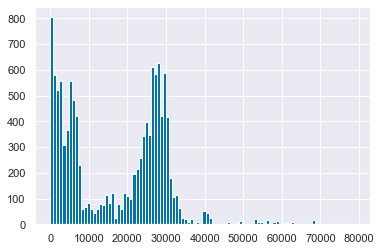

In [337]:
%%time
BES_not_nulls = BES_reduced_with_na[mask].notnull().sum()
BES_not_nulls.hist(bins=100);

In [338]:
BES_not_nulls[BES_not_nulls<10000].index

Index(['generalElectionCertaintySqW5__Completely certain',
       'generalElectionCertaintySqW12__Completely certain',
       'generalElectionCertaintyW17__Completely certain',
       'generalElectionCertaintySqW18__Completely certain',
       'likeSalmondW1__Strongly like', 'likeWoodW1__Strongly like',
       'likeSNPW1__Strongly like', 'likePCW1__Strongly like',
       'ptvSNPW1__Very likely', 'ptvPCW1__Very likely',
       ...
       'referendumContact_noneW2_Yes', 'labPriorities2_crimeW4_Yes',
       'conPriorities2_schoolW4_Yes', 'conPriorities2_nhsW4_Yes',
       'conPriorities2_costLiveW4_Yes',
       'devoResponsibleWalesJusticeW2_The UK Parliament',
       'conPriorities2_immigW4_Yes', 'conPriorities2_crimeW4_Yes',
       'partySiteOthW5_Yes', 'conPriorities2_natsecW4_Yes'],
      dtype='object', length=4996)

In [339]:
extra_drop_list = "|".join( ["mainSourceIncome","al\d|al_scale","studentloan","ethnicity","selfOccSupervise","profile_marital_stat",
"ns_sec","JACS_subject_label","schoolKidsInHouse","profile_work_stat","profile_socialgrade_cie","jobzone",
 "profile_work_industry","subjectHE","p_disabilityW10__Yes, limited a lot","p_parentW10__Yes","profile_past_vote",
"selfOcc","goldthorpeW6W7W8W9","profile",
    "homeOwn","secondHome","buyHomeFuture","savings","debt","studentloan",
    "homeamtb","mortgagePayment","secondHomeAmtb","rentPayment","savingsAmtb","debtAmtb",
    "borrowEssentials","smallEmergency","worryEconSecurity",
    "riskPoverty","riskUnemployment",
    "numChildren",
    "forcedSubjClass","subjClass","subjClassSqueeze",
    "currentUnionMember","everUnionMember",
    "abroadCountry","livedAbroad","handed","languageSkills",] )

In [340]:
# drop values in demog list (removing details )

non_demog_df = BES_reduced_with_na[mask]\
    .drop(match(BES_reduced_with_na,"|".join([x.split("W")[0].split("[")[0] for x in demog_var.split("|")]) ).index,axis=1)\
    .drop(BES_not_nulls[BES_not_nulls<10000].index,axis=1,errors='ignore').copy().astype('float32')\
    .drop(match(BES_reduced_with_na,extra_drop_list).index,axis=1,errors='ignore').copy().astype('float32')


non_demog_df["genderRolesW10__Strongly agree"] = BES_reduced_with_na["genderRolesW10__Strongly agree"][mask].astype('float32')

In [341]:
# extra_drop_list

In [342]:
demog_df = BES_reduced_with_na[demog_vars][mask].copy().astype('float32')

In [343]:
non_demog_df.shape, demog_df.shape

((78876, 5126), (78876, 350))

In [251]:
# %%time
# non_demog_df.corrwith( demog_df[demog_df.columns[0]] ).sort_values()

In [309]:
# search(BES_reduced_with_na,"genderRole")

In [344]:
al_split = pd.qcut(pan_dataset_allr_values[al_col][mask],3,).cat.codes

In [381]:
# %%time
# non_demog_df[al_split==0].corrwith( demog_df[demog_df.columns[0]][al_split==0] ).sort_values()

In [427]:
%%time
store_corrs = pd.DataFrame()
BES_notnulls = BES_reduced_with_na[demog_df.columns][mask].notnull()
non_demog_notnulls = non_demog_df>0
min_sample_size=100

for demo_var in demog_df.columns:
    
#     min_sample_al2 = non_demog_df[al_split==2].notnull()[demog_df[demog_df.columns[colno]][al_split==2].notnull()].sum().min()
#     min_sample_al0 = non_demog_df[al_split==0].notnull()[demog_df[demog_df.columns[colno]][al_split==0].notnull()].sum().min()
#     if min(min_sample_al0,min_sample_al2)<500:
#         continue
    # add sample size count
    
    store_corrs[demo_var] = non_demog_df[al_split==2].corrwith( demog_df[demo_var][al_split==2] )\
        - non_demog_df[al_split==0].corrwith( demog_df[demo_var][al_split==0] )
    
    undersampled = non_demog_notnulls[BES_notnulls[demo_var]][(al_split==0)].sum()<min_sample_size
    store_corrs.loc[undersampled[undersampled].index,demo_var] = np.nan
    undersampled = non_demog_notnulls[BES_notnulls[demo_var]][(al_split==2)].sum()<min_sample_size
    store_corrs.loc[undersampled[undersampled].index,demo_var] = np.nan 

Wall time: 1h 15min 51s


In [428]:
# non_demog_df.stack().value_counts()

In [391]:
# non_demog_df[al_split==2].corrwith( demog_df[demo_var][al_split==2] )

In [392]:
# BES_notnulls

In [393]:
# non_demog_notnulls[BES_notnulls[demo_var]][(al_split==0)].sum()<min_sample_size

In [419]:
# lowest = 999999
# lowest_col= ""
# for colno in range(0,len(demog_df.columns)):
#     min_sample = non_demog_df[al_split==2].notnull()[demog_df[demog_df.columns[colno]][al_split==2].notnull()].sum().min()
#     print(demog_df.columns[colno] , min_sample, "al=2" )
#     if min_sample<lowest:
#         lowest=min_sample
#         lowest_col=demog_df.columns[colno]
#     min_sample = non_demog_df[al_split==0].notnull()[demog_df[demog_df.columns[colno]][al_split==0].notnull()].sum().min()
#     print(demog_df.columns[colno] , min_sample, "al=0" )
#     if min_sample<lowest:
#         lowest=min_sample
#         lowest_col=demog_df.columns[colno]        
        
# print("**************************")
# print(lowest_col,lowest)

In [316]:
# store_corrs[store_corrs.columns[0]].dropna().abs().sort_values().tail(50)

In [317]:
# store_corrs.abs().max().max()

1.6793478580615395

In [429]:
store_corrs.abs().idxmax().head(50)

riskPovertyW1__Very likely                                                                          lr1W10W11W12__Strongly agree
riskUnemploymentW1__Very likely                                                                                   lrLDW17__Right
riskPovertyW2__Very likely                                                     mpVoteConstSelfW17_MP should vote according to...
riskUnemploymentW2__Very likely                                                                                   lrLDW18__Right
riskPovertyW3__Very likely                                                          EUIntegrationConW6__Protect our independence
riskUnemploymentW3__Very likely                                                     EUIntegrationConW1__Protect our independence
riskPovertyW4__Very likely                                                     mpVoteConstSelfW17_MP should vote according to...
riskUnemploymentW4__Very likely                                                                  

In [430]:
store_corrs.abs().max().dropna().sort_values().tail(50)

mainSourceIncomeW6_Jobseeker's Allowance / Unemployment benefit              0.237814
mainSourceIncomeW6_Earnings from employment (own or spouse / partner's)      0.237876
edlevelW8W9W10__Postgrad                                                     0.240038
mainSourceIncomeW6_Income Support or family credit                           0.240432
countryOfBirth_Other: European Union member country                          0.245622
subjClassW15_No                                                              0.247995
riskPovertyW8__Very likely                                                   0.252809
subjClassW16_Yes, working class                                              0.253549
debtAmtbW14__£200,000 or above                                               0.255614
selfOccSuperviseW17_Yes                                                      0.259761
currentUnionMemberW16_Yes                                                    0.261942
Age                                                   

In [ ]:
profile_gross_personal__£100,000 and over <-> riskUnemploymentW2__Very likely
<-> likeBlairW11__Strongly like
"mainSourceIncomeW6_Occupational pension(s) - from previous employer(s)" <-> competentMayW13__A great deal of competence
<-> mapInequalityW3__Differences in income are very large

In [ ]:
goldthorpeW6W7W8W9 <-> lr1 (lr1W14W15__Strongly ,lr1W10W11W12__Strongly ) DONE
<-> grammarW11 DONE
<-> cutsTooFarNHS DULL
<-> redistSelf

"p_disabilityW10__Yes, limited a lot" <-> generalElectionVoteW10_Conservative

mainSourceIncomeW6_Other state benefit <-> pastvote_eup_2019W19_United Kingdom Independence Party (UKIP)

JACS_subject_labelW19_Area Studies <=> mii_catW5_education

motherCountryBornW8_East Asia <=> partyContactNoneW4_Yes
JACS_subject_labelW19_Veterinary science <-> partyContactNoneW6_Yes

mainSourceIncomeW11_Student grant or loan <-> bestOnMIIW1_Plaid Cymru
mainSourceIncomeW6_Student grant or loan <-> mii_catW2_racism/discrimination
mainSourceIncomeW6_Income Support or family credit <-> generalElectionVoteUnsqueezeW17_Brexit Party
mainSourceIncomeW6_Dependent on parents/other relatives<->mii_catW10_societal divides

mainSourceIncomeW6_Interest from savings or investments<->negotiationSpecifics_noneW15_Yes
<->mii_catW10_pensions/ageing
<->mii_catW10_nat ident, goals-loss

mainSourceIncomeW6_Jobseeker's Allowance / Unemployment benefit<->achieveReduceImmigLabW17_Yes
<-> localElectionVoteW12_Labour

profile_religion_Yes - Free Presbyterian <-> mii_catW9_economy-personal

buyHomeFutureW14_Yes, I will be able to buy a home outright <->mii_catW2_racism/discrimination,racismAmountW4__A lot

buyHomeFutureW14_Yes, I will be able to buy with a mortgage<->integrityCorbynW13__Complete integrity,competentCorbynW13__A great deal of competence

languageSkillsWelshW8_Yes <-> econGenRetroW8__Got ,euID6W16__Strongly (other euref vars)

mortgagePaymentW14__100.0 <-> spendMost4W2_Education,likeBattenW15__Strongly like (surely DK%?)

subjClassSqueezeW19_Working class <-> ptvCon

secondHomeAmtbW14__£1 million or above <-> pidWeTheyW17__Strongly agree

rentPaymentW14 ??? <-> prevJob

subjClassW15_Yes, working class <-> 
ptvGrnW16__Very likely                                                      0.298967
smallPartyWastedVoteW17__Strongly agree                                     0.272752
lr2W17__Strongly agree                                                      0.236520
ptvGrnW17__Very likely                                                      0.235443
leftRightW18__Right                                                         0.228563

In [438]:
ind_var = "profile_gross_household__£150,000 and over"
ind_var = "Age"
# ind_var = "gender_Female"
ind_var = "profile_gross_personal__£100,000 and over"
ind_var = "mainSourceIncomeW6_Occupational pension(s) - from previous employer(s)"
ind_var = "mainSourceIncomeW6_Other state benefit"
ind_var = "goldthorpeW6W7W8W9"
ind_var = "p_parentW10__Yes"
ind_var = "p_disabilityW10__Yes, limited a lot"
ind_var = "mortgagePaymentW14__100.0"
ind_var = "mainSourceIncomeW6_Other state benefit"
ind_var = "JACS_subject_labelW19_Area Studies"
ind_var = "gorW10_Scotland"
ind_var = "countryOfBirth_England"
ind_var = "motherCountryBornW8_East Asia"
ind_var = "JACS_subject_labelW19_Veterinary science"
ind_var = "mainSourceIncomeW11_Student grant or loan"
ind_var = "mainSourceIncomeW6_Income Support or family credit"
ind_var = "profile_religion_Yes - Free Presbyterian"
ind_var = "mainSourceIncomeW6_Student grant or loan"
ind_var = "mainSourceIncomeW6_Dependent on parents/other relatives"
ind_var = "mainSourceIncomeW6_Interest from savings or investments"
ind_var = "fatherCountryBornW8_East Asia"
ind_var = "mainSourceIncomeW6_Jobseeker's Allowance / Unemployment benefit"
ind_var = "buyHomeFutureW14_Yes, I will be able to buy a home outright"
ind_var = "buyHomeFutureW14_Yes, I will be able to buy with a mortgage"
ind_var = "profile_ethnicity_Pakistani"
ind_var = "Age"
ind_var = "selfOccSuperviseW2_Yes"
ind_var = "languageSkillsWelshW8_Yes"
ind_var = "mortgagePaymentW14__100.0"
ind_var = "subjClassSqueezeW19_Working class"
ind_var = "secondHomeAmtbW14__£1 million or above"
ind_var = "rentPaymentW14"
ind_var = "subjClassW15_Yes, working class"

store_corrs[ind_var].dropna().abs().sort_values(ascending=False).head(50)

ptvGrnW16__Very likely                                                      0.298967
smallPartyWastedVoteW17__Strongly agree                                     0.272752
lr2W17__Strongly agree                                                      0.236520
ptvGrnW17__Very likely                                                      0.235443
leftRightW18__Right                                                         0.228563
grnUnitedW16__Very united                                                   0.225900
likePhillipsW19__Strongly like                                              0.222483
redistLDW17__Government should be less concerned about equal incomes        0.213352
grnUnitedW17__Very united                                                   0.211040
likeSoubryW15__Strongly like                                                0.206213
leftRightW17__Right                                                         0.202342
infoSourcePaperW18__More than 2 hours                            

In [439]:
store_out = pd.concat([store_corrs.abs().idxmax(),store_corrs.abs().max()],axis=1)
store_out.columns = ["max_regressor","max_correlation"]
store_out.sort_values(by="max_correlation",ascending=False).head(50)

max_regressor  \
gorW10_Scotland                                              happyScotIndepResultW17__Extremely happy   
countryOfBirth_Scotland                                      happyScotIndepResultW17__Extremely happy   
countryOfBirth_England                                       happyScotIndepResultW17__Extremely happy   
selfOccSuperviseW2_Yes                                                 immigEconW13__Good for economy   
selfOccSuperviseLastW11_Yes                           generalElectionCertaintyW11__Completely certain   
languageSkillsWelshW8_Yes                                            econGenRetroW8__Got a lot better   
selfOccSuperviseW4_Yes                                                       euID7W16__Strongly agree   
selfOccSuperviseLastW15_Yes                                                            lrLDW18__Right   
selfOccSuperviseLastW2_Yes                                         trustMPsW18__A great deal of trust   
selfOccSuperviseLastW14_Yes                                          happyNIIndepResultScaleW17__10.0   
mortgagePaymentW14__100.0                                                      spendMost4W2_Education   
selfOccSuperviseLastW9_Yes                                                           lrUKIPW16__Right   
selfOccSuperviseLastW4_Yes                          eesEUIntegrationLabW4__Unification should be p...   
selfOccSuperviseW15_Yes                                              majorityPartyLabW18__Very likely   
selfOccSuperviseLastW7_Yes                                 natSecurityGrnW11__Protect civil liberties   
selfOccSuperviseW3_Yes                                           regSatisfactionW4__Very dissatisfied   
selfOccSuperviseW12_Yes                                                headHouseholdPastW13_My father   
subjClassSqueezeW19_Working class                                               ptvConW5__Very likely   
selfOccSuperviseW11_Yes                                            efficacyPolCareW15__Strongly agree   
selfOccSuperviseLastW10_Yes                         winConstituencyGreenW17__100 - Very likely to win   
selfOccSuperviseW10_Yes                                                      partyContactCon_2W13_Yes   
selfOccSuperviseW7_Yes                                                      voteMethodEurope_2W16_Yes   
rentPaymentW14                                                                         prevJobW19_Yes   
mainSourceIncomeW6_Occupational pension(s) - fr...  mapInequalityW3__Differences in income are ver...   
subjClassW15_Yes, working class                                                ptvGrnW16__Very likely   
selfOccSuperviseW14_Yes                                                      euID6W17__Strongly agree   
secondHomeAmtbW14__£1 million or above                                   pidWeTheyW17__Strongly agree   
selfOccSuperviseLastW3_Yes                                         preferConCoalitionW5__Ranked fifth   
selfOccSuperviseW9_Yes                                                             lrBrexitW17__Right   
buyHomeFutureW14_Yes, I will be able to buy wit...                   likeLongBaileyW19__Strongly like   
subjClassW15_Yes, middle class                                      mpBrexitViewW17__Strongly support   
forcedSubjClassW14_Working class                                                 ptvLDW3__Very likely   
currentUnionMemberW17_Yes                             winConstituencyConW18__100 - Very likely to win   
gender_Female                                       mpVoteConstSelfW17_MP should vote according to...   
everUnionMemberW16_Yes                                                achieveReduceImmigBrexitW17_Yes   
everUnionMemberW17_Yes                                winConstituencyConW17__100 - Very likely to win   
mainSourceIncomeW6_Invalidity, sickness or disa...                                spendMost1W2_Health   
buyHomeFutureW14_No, I will not be able to purc...                           likeConW4__Strongly l

In [265]:
store_out.loc[[x for x in store_out.index if "__" in x]].sort_values(by="max_correlation",ascending=False)

max_regressor  \
edlevelW8W9W10__Postgrad                                                       lr1W17__Strongly agree   
profile_gross_personal__£100,000 and over                         profile_past_vote_2005_Conservative   
profile_education_age__Still at school/Full tim...  redistSelfW15__Government should be less conce...   
anyUniW10__Yes, I graduated from higher education                                  studentloanW14_Yes   
profile_socgradeW8__E                                                       lr1W14W15__Strongly agree   
profile_gross_household__£150,000 and over          redistUKIPW14__Government should be less conce...   
profile_household_size__8 or more                               profile_work_statW7_Full time student   
profile_household_children__6 or more               eesEUIntegrationSelfW3__Unification should be ...   

                                                    max_correlation  
edlevelW8W9W10__Postgrad                                   0.205549  
profile_gross_personal__£100,000 and over                  0.197222  
profile_education_age__Still at school/Full tim...         0.191803  
anyUniW10__Yes, I graduated from higher education          0.188896  
profile_socgradeW8__E                                      0.166648  
profile_gross_household__£150,000 and over                 0.156640  
profile_household_size__8 or more                          0.155285  
profile_household_children__6 or more                      0.135666

In [262]:
store_out["max_regressor"].value_counts().head(50)[-50:]

profile_past_vote_2005_Conservative                                                           9
happyScotIndepResultW17__Extremely happy                                                      5
ethnicity2W16_Pakistani                                                                       4
ethnicity2W15_Any other White background                                                      4
ethnicity2W16_Any other Black / African / Caribbean background                                3
mpVoteConstSelfW17_MP should vote according to the opinion of voters in their constituency    3
partyContactNoneW4_Yes                                                                        3
studentloanW14_Yes                                                                            3
ethnicity2W15_Caribbean                                                                       3
profile_work_statW7_Full time student                                                         3
churchAttendanceW6__Once a week or more 

In [257]:
store_out[store_out["max_regressor"]=="mii_catW1_domestic emergency"]

max_regressor  \
profile_ethnicity_White and Black African  mii_catW1_domestic emergency   

                                           max_correlation  
profile_ethnicity_White and Black African         0.204122

In [ ]:
edlevel <-> lr1
profile_education_age <-> redistSelf
educationW8W9W10_University or CNAA higher degree (eg M.Sc, Ph.D) <-> femaleEquality
gorW10_North East	spendLeast2W2_Pensions
educationW8W9W10_CSE grades 2-5	spendMost4W2_Foreign Aid	

In [ ]:
mainSourceIncomeW11_Occupational pension(s) - from previous employer(s)

In [ ]:
profile_religion_No, I do not regard myself as belonging to any particular religion.	churchAttendanceW6__Once a week or more	0.196900
profile_religion_Yes - Church of England/Anglican/Episcopal	churchAttendanceW6__Once a week or more	0.202944
profile_religion_Yes - Methodist	churchAttendanceW6__Once a week or more	0.099835

allSourceIncome_11W11_Yes	mpVoteConstSelfW17_MP should vote according to...	0.090988
allSourceIncome_8W11_Yes	mpVoteConstSelfW17_MP should vote according to...	0.186227
gender_Female	mpVoteConstSelfW17_MP should vote according to...	0.271380

countryOfBirth_England	happyScotIndepResultW17__Extremely happy	0.438435
countryOfBirth_Scotland	happyScotIndepResultW17__Extremely happy	0.481126
educationW8W9W10_Scottish Higher Certificate	happyScotIndepResultW17__Extremely happy	0.152596
gorW10_Scotland	happyScotIndepResultW17__Extremely happy	0.491090
profile_religion_Yes - Presbyterian/Church of Scotland	happyScotIndepResultW17__Extremely happy	0.234409

Age	profile_past_vote_2005_Conservative	0.373387
profile_gross_personal__£100,000 and over	profile_past_vote_2005_Conservative	0.197222
workingStatusW6_W12_Full time university student	profile_past_vote_2005_Conservative	0.263519
marital_Married	profile_past_vote_2005_Conservative	0.212778
marital_Never married	profile_past_vote_2005_Conservative	0.257610
profile_work_typeW7W10_Professional or higher technical work / higher managerial - work that requires at least degree-level qualifications (e.g	profile_past_vote_2005_Conservative	0.185511
profile_work_typeW7W10_Have never worked	profile_past_vote_2005_Conservative	0.221725
profile_house_tenure_Own outright	profile_past_vote_2005_Conservative	0.226980
allSourceIncome_2W11_Yes	profile_past_vote_2005_Conservative	0.226221
                                                                                                                                            
                                                                                                                                            anyUniW10__Yes, I graduated from higher education	studentloanW14_Yes	0.188896
anyUniW10__Yes, I graduated from higher education	studentloanW14_Yes	0.188896
profile_house_tenure_Own with a mortgage	studentloanW14_Yes	0.149310
profile_house_tenure_Rent from a private landlord	studentloanW14_Yes	0.200640
                                                                                                                                            
                                                                                                                                            motherCountryBornW8_East Asia	partyContactNoneW4_Yes	0.409335
fatherCountryBornW8_East Asia	partyContactNoneW4_Yes	0.409486
profile_ethnicity_Chinese	partyContactNoneW4_Yes	0.269650
                                                                                                                                            
profile_sexualityW10_Heterosexual	al_scaleW7W8W9__Authoritarian	0.164327
profile_sexualityW10_Bisexual	al_scaleW7W8W9__Authoritarian	0.151172                                                                                                                                            

In [234]:
match(BES_Panel,"main")

mainSourceIncomeW6      7245
mainSourceIncomeW11    29461
dtype: int64

In [236]:
BES_Panel["mainSourceIncomeW11"].value_counts()

Earnings from employment (own or spouse / partner's)      15728
Occupational pension(s) - from previous employer(s)        5421
State retirement or widow's pension(s)                     3919
Invalidity, sickness or disabled pension or benefit(s)     1135
Student grant or loan                                       654
Don't know                                                  488
Other main source                                           484
Interest from savings or investments                        402
Jobseeker's Allowance / Unemployment benefit                358
Income Support or family credit                             319
Dependent on parents/other relatives                        306
Other state benefit                                         247
Name: mainSourceIncomeW11, dtype: int64

In [247]:
store_corrs_old = store_corrs.copy()# backup

In [ ]:
{"mainSourceIncome","studentloan","selfOccSupervise","ns_sec_analytic","JACS_subject_label",
 "p_disabilityW10__Yes, limited a lot","p_parentW10__Yes","selfOccStatusW6_W12","selfOccSuperviseW6"}


{"mainSourceIncome","al\d|al_scale","studentloan","ethnicity","selfOccSupervise","profile_marital_stat",
"ns_sec","JACS_subject_label","schoolKidsInHouse","profile_work_stat","profile_socialgrade_cie","jobzone",
 "profile_work_industry","subjectHE","p_disabilityW10__Yes, limited a lot","p_parentW10__Yes","profile_past_vote",
"selfOcc"}

In [280]:
search(BES_Panel,"selfOccSupervise")

selfOccSuperviseW1         13377
selfOccSuperviseLastW1     11146
selfOccSuperviseW2          1442
selfOccSuperviseLastW2      1112
selfOccSuperviseW3          1235
selfOccSuperviseLastW3       609
selfOccSuperviseW4          2602
selfOccSuperviseLastW4      1397
selfOccSuperviseW6         13304
selfOccSuperviseLastW6     10950
selfOccSuperviseW7          4024
selfOccSuperviseLastW7      2026
selfOccSuperviseW9          2119
selfOccSuperviseLastW9      2190
selfOccSuperviseW10         3673
selfOccSuperviseLastW10     2296
selfOccSuperviseW11         1335
selfOccSuperviseLastW11      809
selfOccSuperviseW12         1067
selfOccSuperviseLastW12      431
selfOccSuperviseW14         2286
selfOccSuperviseLastW14     1499
selfOccSuperviseW15         2505
selfOccSuperviseLastW15     1327
selfOccSuperviseW16        16862
selfOccSuperviseLastW16    14044
selfOccSuperviseW17         3844
selfOccSuperviseLastW17     3370
selfOccSuperviseW18         1009
selfOccSuperviseLastW18      598
selfOccSup

In [279]:
BES_Panel["selfOccStatusW6_W12"]

id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
        ... 
98447    NaN
98448    NaN
98449    NaN
98450    NaN
98451    NaN
Name: selfOccStatusW6_W12, Length: 97006, dtype: category
Categories (3, object): [Self-employed/independent contractor < An employee < Don't know]

In [442]:
store_corrs.to_pickle("..\\BES_analysis_publications\\Authoritarianism as Mediator\\store_corrs.zip",compression='zip')
store_out.to_pickle("..\\BES_analysis_publications\\Authoritarianism as Mediator\\store_out.zip",compression='zip')